### Preamble

In [197]:
%pip install tldextract
%pip install cryptography
%pip install seaborn
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install matplotlib-venn
# restart the python kernel if packages are not present and freshly installed

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

In [201]:
%run ./spark-instance-gustavo.ipynb

SparkConf created
Started SparkSession
Spark version 3.5.0


In [200]:
clean_spark()

In [ ]:
%matplotlib inline

# system imports
from collections import defaultdict
from datetime import datetime
from fnmatch import fnmatch
import math
from glob import glob
import os
import statistics

# installed packages import
import matplotlib.pyplot as plt
from matplotlib import lines as mlines
import pandas as pd
import numpy as np
import tldextract
from cryptography import x509
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import hashes
import seaborn as sns

# pyspark imports
from pyspark.errors import *
import pyspark.sql.types as pst
import pyspark.sql.functions as psf
from pyspark.storagelevel import StorageLevel
from pyspark.sql.window import Window
import pyspark.pandas as ps

# local imports

In [ ]:
# straight from https://github.com/kennethreitz/requests/blob/master/src/requests/structures.py
from collections import OrderedDict
from collections.abc import MutableMapping


class CaseInsensitiveDict(MutableMapping):
    """A case-insensitive ``dict``-like object.

    Implements all methods and operations of
    ``MutableMapping`` as well as dict's ``copy``. Also
    provides ``lower_items``.

    All keys are expected to be strings. The structure remembers the
    case of the last key to be set, and ``iter(instance)``,
    ``keys()``, ``items()``, ``iterkeys()``, and ``iteritems()``
    will contain case-sensitive keys. However, querying and contains
    testing is case insensitive::

        cid = CaseInsensitiveDict()
        cid['Accept'] = 'application/json'
        cid['aCCEPT'] == 'application/json'  # True
        list(cid) == ['Accept']  # True

    For example, ``headers['content-encoding']`` will return the
    value of a ``'Content-Encoding'`` response header, regardless
    of how the header name was originally stored.

    If the constructor, ``.update``, or equality comparison
    operations are given keys that have equal ``.lower()``s, the
    behavior is undefined.
    """

    def __init__(self, data=None, **kwargs):
        self._store = OrderedDict()
        if data is None:
            data = {}
        self.update(data, **kwargs)

    def __setitem__(self, key, value):
        # Use the lowercased key for lookups, but store the actual
        # key alongside the value.
        self._store[key.lower()] = (key, value)

    def __getitem__(self, key):
        return self._store[key.lower()][1]

    def __delitem__(self, key):
        del self._store[key.lower()]

    def __iter__(self):
        return (casedkey for casedkey, mappedvalue in self._store.values())  # wrong?

    def __len__(self):
        return len(self._store)

    def lower_items(self):
        """Like iteritems(), but with all lowercase keys."""
        return ((lowerkey, keyval[1]) for (lowerkey, keyval) in self._store.items())

    def __eq__(self, other):
        if isinstance(other, MutableMapping):  # changed this line
            other = CaseInsensitiveDict(other)
        else:
            return NotImplemented
        # Compare insensitively
        return dict(self.lower_items()) == dict(other.lower_items())

    # Copy is required
    def copy(self):
        return CaseInsensitiveDict(self._store.values())

    def __repr__(self):
        return str(dict(self.items()))


In [ ]:
from ip_as_org import IPASnPrefix, ASOrg

def get_ip_asn_as_org_obj(timestamps):
    dates = [ts.strftime("%Y%m%d") for ts in timestamps]
    dataset_dir = "../dataset/"
    ip_asn = IPASnPrefix(dates, dataset_dir)
    as_org = ASOrg(dates, dataset_dir)
    return ip_asn, as_org

def ip_to_country(ip: str, when: str) -> str:
    asn = ip_asn.get_asn_from_ip(ip, when)
    if asn is None:
        return "Unknown"
    try:
        country = as_org.get_country_from_asn(asn, when)
    except ValueError:
        country = "Unknown"
    return country

def ip_to_org(ip: str, when: str) -> str:
    asn = ip_asn.get_asn_from_ip(ip, when)
    if asn is None:
        return "Unknown"
    try:
        org = as_org.get_org_name_from_asn(asn, when)
    except ValueError:
        org = "Unknown"
    return org


ip_to_country_udf = psf.udf(ip_to_country, pst.StringType())
ip_to_org_udf = psf.udf(ip_to_org, pst.StringType())

In [253]:
plt.rcParams["font.family"] = 'Nimbus Roman'   #"Times"
sns.set_theme(font='Nimbus Roman')
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})  # "whitegrid"
sns.set_palette("husl", 4)
sns.color_palette("husl", 4)

ps.set_option('compute.ops_on_diff_frames', True)
pd.options.plotting.backend = 'matplotlib'

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727)]

### Extracting Goscanner data

In [ ]:
#####################
### LOAD DATA
#####################
def load_hosts_data(port, ts):
    hosts_base_path = HOSTS_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    hosts_df = spark.read.option("header", "true") \
                         .option("lineSep", "\n") \
                         .option("quote", "\"") \
                         .option("escape", "\"") \
                         .option("inferSchema", "true") \
                         .csv(f"../dataset/{hosts_base_path}")
    return hosts_df


def load_certs_data(port, ts):
    certs_base_path = CERTS_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    certs_df = spark.read.option("header", "true") \
                         .option("multiline", "true") \
                         .option("wholeFile", "true") \
                         .option("inferSchema", "true") \
                         .csv(f"../dataset/{certs_base_path}")
    return certs_df


def load_tls_data(port, ts):
    tls_base_path = TLS_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    tls_df = spark.read.option("header", "true") \
                       .option("multiline", "true") \
                       .option("wholeFile", "true") \
                       .option("inferSchema", "true") \
                       .csv(f"../dataset/{tls_base_path}")
    return tls_df


def load_ldap_data(port, ts):
    ldap_base_path = LDAP_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    ldap_df = spark.read.option("header", "true") \
                        .option("lineSep", "\n") \
                        .option("quote", "\"") \
                        .option("escape", "\"") \
                        .option("inferSchema", "true") \
                        .csv(f"../dataset/{ldap_base_path}")
    return ldap_df


def load_ldapstarttls_data(port, ts):
    starttls_base_path = STARTTLS_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    starttls_df = spark.read.option("header", "true") \
                            .option("lineSep", "\n") \
                            .option("quote", "\"") \
                            .option("escape", "\"") \
                            .option("inferSchema", "true") \
                            .csv(f"../dataset/{starttls_base_path}")
    return starttls_df


def load_cert_validator(port, ts):
    cert_validator_base_path = CERTVAL_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    df = spark.read.option("basePath", f"../dataset/{cert_validator_base_path}")\
                   .parquet(f"../dataset/{cert_validator_base_path}")
    return df


def convert_ldap_attributes(df):
    df = df.withColumn("asd", eval_list_list_str_udf(psf.col("attribute_names")))
    df = df.drop("attribute_names")
    df = df.withColumnRenamed("asd", "attribute_names")
    df = df.withColumn("qwe", eval_list_list_list_str_udf(psf.col("attribute_values_list")))
    df = df.drop("attribute_values_list")
    df = df.withColumnRenamed("qwe", "attribute_values_list")
    return df


def flatten_ldap_metadata(df):
    df = df.select("id", "ip", "port", "result_code", "error_data", "matched_dns",
                                    psf.explode_outer(psf.arrays_zip(
                                                      df.attribute_names,
                                                      df.attribute_values_list)))
    df = df.select("id", "ip", "port", "result_code", "error_data", "matched_dns", "col.attribute_names", "col.attribute_values_list")
    df = df.select("id", "ip", "port", "result_code", "error_data", "matched_dns",
                                    psf.explode_outer(psf.arrays_zip(
                                                      df.attribute_names,
                                                      df.attribute_values_list)))
    df = df.select("id", "ip", "port", "result_code", "error_data", "matched_dns", "col.attribute_names", "col.attribute_values_list")
    df = df.withColumnRenamed("attribute_names", "attribute_name")
    return df


def flat_ldap_attr_values(df):
    # good for vendorName filters for example
    df = df.select("id", "ip", "port", "result_code", "error_data", "matched_dns", "attribute_name", psf.explode_outer(df.attribute_values_list))
    df = df.withColumnRenamed("col", "attribute_value")
    return df


def load_ldap_root_dse(port, ts):
    root_dse_base_path = ROOT_DSE_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    df = spark.read.option("header", "true") \
                   .option("multiline", "true") \
                   .option("wholeFile", "true") \
                   .option("inferSchema", "true") \
                   .csv(f"../dataset/{root_dse_base_path}")

    df = convert_ldap_attributes(df)
    return df


def load_ldap_schema(port, ts):
    schema_base_path = SCHEMA_PATH_FMT.format(port=port, year=ts.year, month=ts.month, day=ts.day)
    df = spark.read.option("header", "true") \
                   .option("multiline", "true") \
                   .option("wholeFile", "true") \
                   .option("inferSchema", "true") \
                   .csv(f"../dataset/{schema_base_path}")

    df = convert_ldap_attributes(df)
    return df

##########################
### UDF
##########################
def convert_output_df(df):
    df = df.select("id", "generic_error", psf.explode("root_stores").alias("store_name", "result"))
    df = df.select("id", "generic_error", "store_name", "result.*")
    df = df.withColumn("vc", eval_list_list_str_udf(psf.col("valid_chains")))
    df = df.drop("valid_chains")
    df = df.withColumnRenamed("vc", "valid_chains")
    return df


len_udf = psf.udf(lambda chain: [len(x) for x in chain], pst.ArrayType(pst.IntegerType()))


def chain_len(df):
    df = df.withColumn("chain_len", len_udf(psf.col("valid_chains")))
    df.select("chain_len").groupBy(psf.col("chain_len")).count().show()
    return df


def peer_certs_len(peer_certs_str):
    peer_certs = eval_list(peer_certs_str)
    return len(peer_certs)


peer_certs_len_udf = psf.udf(peer_certs_len, pst.IntegerType())


get_list_len_udf = psf.udf(lambda l: len(l), pst.IntegerType())


def eval_list_list_list_str(my_list):
    try:
        if isinstance(my_list, str):
            return eval(my_list)
        else:
            return [[[]]]
    except:
        return [[[]]]


eval_list_list_list_str_udf = psf.udf(eval_list_list_list_str, pst.ArrayType(pst.ArrayType(pst.ArrayType(pst.StringType()))))


def eval_list_list_str(my_list):
    try:
        if isinstance(my_list, str):
            return eval(my_list)
        else:
            return [[]]
    except:
        return [[]]


eval_list_list_str_udf = psf.udf(eval_list_list_str, pst.ArrayType(pst.ArrayType(pst.StringType())))


def eval_list(my_list):
    try:
        if isinstance(my_list, str):
            return eval(my_list)
        else:
            return []
    except:
        return []


eval_udf = psf.udf(eval_list, pst.ArrayType(pst.IntegerType()))


SHORT1 = "Signed by unknown authority"
SHORT2 = "Expired/Not yet valid"
SHORT3 = "Not authorized to sign other certificates"
SHORT4 = "Too many intermediate certificates"
SHORT5 = "Unhandled critical extension"
SHORT6 = "Other errors"
SHORT7 = "Self-signed"
SHORT8 = "Valid chain"
SHORT9 = "Invalid signature"  # under SHORT1


short_error_name_map = {
    'x509: certificate signed by unknown authority': SHORT1,
    'x509: certificate signed by unknown authority - With possible explanation': SHORT1,
    'x509: certificate has expired or is not yet valid': SHORT2,
    'x509: certificate is not authorized to sign other certificates': SHORT3,
    'x509: too many intermediates for path length constraint': SHORT4,
    'x509: unhandled critical extension': SHORT5,
    'x509: certificate signed by unknown authority (possibly because of "x509: invalid signature': SHORT9,
    '': SHORT8
}


def error_str(error_list, skid, akid, peer_certs_len):
    # test that all elements are empty
    if all(not element for element in error_list):
        return SHORT8

    # get the first non-empty error
    for error_data in error_list:
        if error_data != "":
            break

    parsed_error = ':'.join(error_data.split(":")[:3])
    if "certificate signed by unknown authority" in parsed_error:
        #if peer_certs_len == 1:
        if skid == "" or akid == "":
            if peer_certs_len == 1:
                return SHORT7
        elif skid == akid:
            return SHORT7

    error = short_error_name_map.get(parsed_error, None)
    if error is None:
        parsed_error = ':'.join(error_data.split(":")[:2])
        return short_error_name_map[parsed_error]
    return error


error_str_udf = psf.udf(error_str, pst.StringType())


def error_str2(error_list): #, peer_certs_len):
    # test that all elements are empty
    if all(not element for element in error_list):
        return SHORT8

    # get the first non-empty error
    for error_data in error_list:
        if error_data != "":
            break

    parsed_error = ':'.join(error_data.split(":")[:3])
    #if "certificate signed by unknown authority" in parsed_error:
    #    if peer_certs_len == 1:
    #        return SHORT7

    error = short_error_name_map.get(parsed_error, None)
    if error is None:
        parsed_error = ':'.join(error_data.split(":")[:2])
        return short_error_name_map[parsed_error]
    return error


error_str2_udf = psf.udf(error_str2, pst.StringType())


####################
### SCANTIME
####################
# port 636 scans occurs one day earlier than port 389
PORT_SCANDATE_MAP = {
    636: [
        datetime(2023, 11, 7),
        datetime(2023, 11, 14),
        datetime(2023, 11, 21),
        datetime(2023, 11, 28)
    ],
    389: [
        #datetime(2023, 11, 1),  # no 636 pair
        datetime(2023, 11, 8),
        datetime(2023, 11, 15),
        datetime(2023, 11, 22),
        datetime(2023, 11, 29)
    ]
}
"""
PORT_SCANDATE_MAP = {
    636: [
        datetime(2024, 2, 20),
        datetime(2024, 2, 27),
        datetime(2024, 3, 5),
        datetime(2024, 3, 12),
        datetime(2024, 3, 19)
    ],
    389: [
        datetime(2024, 2, 21),
        datetime(2024, 2, 28),
        datetime(2024, 3, 6),
        datetime(2024, 3, 13),
        datetime(2024, 3, 20)
    ]
}
"""
"""
PORT_SCANDATE_MAP = {
    636: [datetime(2024, 4, 23)],
    389: [datetime(2024, 4, 24)],
}
"""
METADATA_PORT_SCANDATE_MAP = {
    636: datetime(2024, 4, 23),
    389: datetime(2024, 4, 24)
}

goscanner_timestamps = []
for dates in PORT_SCANDATE_MAP.values():
    goscanner_timestamps.extend(dates)
goscanner_timestamps.sort()
goscanner_snapshots = []
for i in range(0, len(goscanner_timestamps), 2):
    goscanner_snapshots.append((goscanner_timestamps[i], goscanner_timestamps[i+1]))

try:
    chosen_snapshot
except NameError:
    chosen_snapshot = goscanner_snapshots[1]


######################
### PATH
######################
HOSTS_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=tcp/result=hosts/year={year}/month={month:02d}/day={day:02d}"
CERTS_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=tls/result=certs/year={year}/month={month:02d}/day={day:02d}"
TLS_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=tls/result=tls_verbose/year={year}/month={month:02d}/day={day:02d}"
LDAP_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=ldap/result=ldap/year={year}/month={month:02d}/day={day:02d}"
STARTTLS_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=starttls_ldap/result=starttls_ldap/year={year}/month={month:02d}/day={day:02d}"
CERTVAL_PATH_FMT = "catrin/data_processing/tool=cert-validator/format=parquet/port={port}/year={year}/month={month:02d}/day={day:02d}"
SCHEMA_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=ldap_metadata/result=ldap_schema/year={year}/month={month:02d}/day={day:02d}"
ROOT_DSE_PATH_FMT = "catrin/measurements/tool=goscanner/format=raw/port={port}/scan=ldap_metadata/result=ldap_root_dse/year={year}/month={month:02d}/day={day:02d}"


########################
### TLS VERSION DECODE
########################
tls_version_str_dict = {
    int("0x0301", 16): "TLSv1.0",
    int("0x0302", 16): "TLSv1.1",
    int("0x0303", 16): "TLSv1.2",
    int("0x0304", 16): "TLSv1.3",
    int("0x0300", 16): "SSLv3"
}


def tls_version_to_string(version_number: int):
    return tls_version_str_dict.get(version_number, str(version_number))


tls_version_udf = psf.udf(tls_version_to_string, pst.StringType())


#################################
### TLS CIPHERSUITE NAME DECODE
#################################
def convert_cipher(x):
    try:
        parts = [int(part, 16) for part in x.split(",")]
    except ValueError:
        # to cover reserved values like 0x00,0x1C-1D
        return None
    cipher = parts[0] << 8
    cipher |= parts[1]
    return hex(cipher)[2:]


# https://www.iana.org/assignments/tls-parameters/tls-parameters.xhtml#tls-parameters-4
tls_parameters_pdf = pd.read_csv("tls-parameters-4.csv")
tls_parameters_pdf["Cipher"] = tls_parameters_pdf["Value"].apply(convert_cipher)
tls_parameters_pdf["DTLS-OK"] = tls_parameters_pdf["DTLS-OK"].apply(lambda x: str(x))
tls_parameters_pdf["Recommended"] = tls_parameters_pdf["Recommended"].apply(lambda x: str(x))
tls_parameters_pdf["Reference"] = tls_parameters_pdf["Reference"].apply(lambda x: str(x))
tls_parameter_dict = tls_parameters_pdf[["Cipher", "Description"]].set_index("Cipher").to_dict()["Description"]


def cipher_to_description(cipher):
    return tls_parameter_dict.get(cipher, "Unknown")


cipher_to_description_udf = psf.udf(cipher_to_description, pst.StringType())

In [ ]:
# Decoding X.509 certificates
def get_x509(pem: str):
    return x509.load_pem_x509_certificate(str.encode(pem), default_backend())


def get_extensions(cert):
    tls_key_exchange = []
    san_list = []
    try:
        extensions = cert.extensions
        for extension in extensions:
            if isinstance(extension.value, x509.TLSFeature):
                tls_key_exchange.append(extension.value.key_exchange)
                continue
            if isinstance(extension.value, x509.SubjectAlternativeName):
                subject_alt_name = extension.value
                san_list += [name for name in subject_alt_name.get_values_for_type(x509.DNSName)]
                continue
    except:
        pass

    return tls_key_exchange, san_list


def get_x509_fields(pem: str):
    try:
        cert = get_x509(pem)
    except ValueError:
        # the certificate contains bytes that cannot be interpreted. Probably invalid cert
        # https://github.com/pyca/cryptography/issues/6804
        print(pem)
        return 11 * [None]  # CHANGE HERE IN CASE ADDITIONAL RETURN PARAMETER

    _, san_list = get_extensions(cert)
    
    subject_rdns = []
    issuer_rdns = []
    try:
        issuer_rdns = [rdn.rfc4514_string() for rdn in cert.issuer.rdns]
        subject_rdns = [rdn.rfc4514_string() for rdn in cert.subject.rdns]
    except ValueError:
        # the certificate contains bytes that cannot be interpreted. Probably invalid cert
        # https://github.com/pyca/cryptography/issues/6804
        pass

    not_valid_after = None
    try:
        if cert.not_valid_after > datetime.min:
            not_valid_after = cert.not_valid_after
    except ValueError:
        # ValueError: year 0 is out of range
        pass
    not_valid_before = None
    try:
        if cert.not_valid_before > datetime.min:
            not_valid_before = cert.not_valid_before
    except ValueError:
        # ValueError: year 0 is out of range
        pass

    public_key_size = None
    try:
        public_key_size = cert.public_key().key_size
    except AttributeError:
        #'cryptography.hazmat.bindings._rust.openssl.ed25519' object has no attribute 'key_size'
        pass

    cert_fp = cert.fingerprint(hashes.SHA256()).hex().upper()

    skid = ""
    try:
        skid = cert.extensions.get_extension_for_oid(x509.oid.ExtensionOID.SUBJECT_KEY_IDENTIFIER).value.digest.hex().upper()
    except:
        # x509.ExtensionNotFound
        # Parse error
        pass
    
    akid = ""
    try:
        akid = cert.extensions.get_extension_for_oid(x509.oid.ExtensionOID.AUTHORITY_KEY_IDENTIFIER).value.key_identifier.hex().upper()
    except:
        # x509.ExtensionNotFound
        # Parse error
        pass
    
    return (cert.signature_algorithm_oid._name,
            public_key_size,
            san_list,
            cert_fp,
            skid,
            akid,
            subject_rdns,
            issuer_rdns,
            cert.version.name,
            not_valid_after,
            not_valid_before,
           )


pem_decoded_schema = pst.StructType([pst.StructField("tls_signature_algorithm", pst.StringType(), True),
                                     pst.StructField("pubkey_bit_size", pst.IntegerType(), True),
                                     pst.StructField("leaf_data_names", pst.ArrayType(pst.StringType()), True),  # SAN
                                     pst.StructField("fingerprint", pst.StringType(), True),
                                     pst.StructField("subject_key_identifier", pst.StringType(), True),
                                     pst.StructField("authority_key_identifier", pst.StringType(), True),
                                     pst.StructField("subject_rdns", pst.ArrayType(pst.StringType()), True),
                                     pst.StructField("issuer_rdns", pst.ArrayType(pst.StringType()), True),
                                     pst.StructField("version", pst.StringType(), True),
                                     pst.StructField("not_valid_after", pst.TimestampType(), True),
                                     pst.StructField("not_valid_before", pst.TimestampType(), True),
                                    ])


decode_cert_udf = psf.udf(get_x509_fields, pem_decoded_schema)

### Loading Goscanner data extracted from the cluster

In [202]:
# data extracted using different notebook (ldap-dependency-goscanner-data-preparation.ipynb).
#goscanner_df = spark.read.parquet(f"../dataset/catrin/ldap-dependency-2023Nov-goscanner.parquet")
try:
    goscanner_df.unpersist()
    goscanner_certs_df.unpersist()
except NameError:
    pass

goscanner_df = spark.read.parquet("../dataset/processing/2023-11-hosts_certs_certval_tls-nopreprocess.parquet")

goscanner_df = goscanner_df.withColumn("decoded_cert", decode_cert_udf(psf.col("cert"))).select("decoded_cert.*", "*").drop("decoded_cert")

goscanner_df = goscanner_df.withColumn("peer_certs_len", peer_certs_len_udf(psf.col("peer_certificates")))
goscanner_df = goscanner_df.withColumn("chain_error", error_str2_udf(psf.col("root_store_error_list")))

goscanner_certs_df = spark.read.parquet("../dataset/processing/2023-11-hosts_peercerts_certval-nopreprocess.parquet")

# below method suppressed by crypto check in the cert (see x509 analysis)
#self_signed_udf = psf.udf(lambda error_str: error_str == SHORT7, pst.BooleanType())
#goscanner_df = goscanner_df.withColumn("tls_signature_self_signed", self_signed_udf(psf.col("chain_error")))

In [203]:
goscanner_df.persist()
goscanner_certs_df.persist()

DataFrame[id: int, ipv4: string, port: int, store_name_list: array<string>, valid_list: array<boolean>, root_store_error_list: array<string>, date: timestamp, peer_certificates: array<int>, certificates: array<string>]

### Extracting Censys data

see ldap-dependency-goscanner-data-preparation.ipynb  

In [ ]:
DATASET = "universal-internet-dataset"
CENSYS_BASE_PATH_FMT = "censys/dataset={dataset}/format=parquet"
CENSYS_PATH_FMT = os.path.join(CENSYS_BASE_PATH_FMT, "year={year}/month={month:02d}/day={day:02d}")

# Censys snapshot of 2022-Nov
censys_timestamps = [
    datetime(2022, 11, 1),
    datetime(2022, 11, 8),
    datetime(2022, 11, 15),
    datetime(2022, 11, 22),
    datetime(2022, 11, 29),
]


def load_censys_data(ts):
    censys_base_path = CENSYS_PATH_FMT.format(dataset=DATASET, year=ts.year, month=ts.month, day=ts.day)
    try:
        censys_df = spark.read.option("basePath", f"../dataset/{censys_base_path}").parquet(f"../dataset/{censys_base_path}")
    except AnalysisException as e:
        print(e)
    return censys_df


def filter_df_by_label(df, ts, label: str):
    llabel = label.lower()

    ser_filtered_df = df.select('*').where((psf.array_contains(psf.col("service_names_list"), label.upper())))
    ser_filtered_df = ser_filtered_df.withColumn("filter_source", psf.lit("service_name"))

    if False:
        dns_filtered_df = df.select('*').filter(
            (psf.expr(f"exists(dns_names, x -> lower(x) like '%.{llabel}.%') or exists(dns_names, x -> lower(x) like '{llabel}.%')")) | 
            (psf.expr(f"exists(r_dns_names, x -> lower(x) like '%.{llabel}.%') or exists(r_dns_names, x -> lower(x) like '{llabel}.%')"))
        )
        dns_filtered_df = dns_filtered_df.withColumn("filter_source", psf.lit("dns_rdns"))

        filtered_df = ser_filtered_df.unionByName(dns_filtered_df)
        uniq_filtered_df = filtered_df.dropDuplicates(["ipv4"])
        uniq_filtered_df = uniq_filtered_df.withColumn("date", psf.lit(ts).cast(pst.TimestampType()))

    return ser_filtered_df


ip_asn, as_org = get_ip_asn_as_org_obj(censys_timestamps)

In [ ]:
CENSYS_TS_DICT = {}
for ts in censys_timestamps:
    print(ts)
    _censys_df = load_censys_data(ts)

    select_df = _censys_df.select("host_identifier.ipv4",
                                 _censys_df.dns.names.alias("dns_names"),
                                 _censys_df.dns.reverse_dns.names.alias("r_dns_names"),
                                 "service_names_list",
                                 "services.port",
                                 _censys_df.services.tls.certificates.leaf_data.names.alias("leaf_data_names"),
                                 _censys_df.services.tls.version_selected.alias("tls_version"),
                                 _censys_df.services.tls.cipher_selected.alias("tls_cipher"),
                                 "services.tls.certificates.leaf_data.pubkey_bit_size",
                                 _censys_df.services.tls.certificates.leaf_data.signature.self_signed.alias("tls_signature_self_signed"),
                                 _censys_df.services.tls.certificates.leaf_data.signature.signature_algorithm.alias("tls_signature_algorithm"),
                                 _censys_df.services.tls.certificates.leaf_data.subject.common_name.alias("cert_cn"),
                                 _censys_df.services.tls.certificates.leaf_data.issuer.common_name.alias("issuer_cn")
                                )

    uniq_filtered_df = filter_df_by_label(select_df, ts, "ldap")

    when = ts.strftime("%Y%m%d")
    #uniq_filtered_df = uniq_filtered_df.withColumn("country", ip_to_country_udf(psf.col("ipv4"), psf.lit(when)))
    #uniq_filtered_df = uniq_filtered_df.withColumn("org", ip_to_org_udf(psf.col("ipv4"), psf.lit(when)))
    uniq_filtered_df = uniq_filtered_df.withColumn("date", psf.lit(ts).cast(pst.TimestampType()))

    CENSYS_TS_DICT[ts] = uniq_filtered_df
print("-------")

2022-11-01 00:00:00
2022-11-08 00:00:00
2022-11-15 00:00:00
2022-11-22 00:00:00
2022-11-29 00:00:00
-------


In [ ]:
try:
    censys_compact_df.unpersist()
except:
    pass

dfs = [df for df in CENSYS_TS_DICT.values()]

censys_compact_df = dfs[0].unionByName(dfs[1])
for i in range(2, len(dfs)):
    censys_compact_df = censys_compact_df.unionByName(dfs[i])

censys_compact_df.persist()

DataFrame[ipv4: string, dns_names: array<string>, r_dns_names: array<string>, service_names_list: array<string>, port: array<bigint>, leaf_data_names: array<array<string>>, tls_version: array<string>, tls_cipher: array<string>, pubkey_bit_size: array<int>, tls_signature_self_signed: array<boolean>, tls_signature_algorithm: array<string>, cert_cn: array<array<string>>, issuer_cn: array<array<string>>, filter_source: string, date: timestamp]

#### Why not use Censys organization and country information?

In [ ]:
# NOT REQUIRED TO RUN!
load_censys_data(ts).select("host_identifier.ipv4", "autonomous_system.organization", "autonomous_system.country_code").filter(psf.col("organization").isNotNull()).show()
censys_compact_df.select("ipv4", "org", "country", "date").filter(psf.col("date") == ts).show(3)

+----+------------+------------+
|ipv4|organization|country_code|
+----+------------+------------+
+----+------------+------------+

+--------------+--------------------+-------+-------------------+
|          ipv4|                 org|country|               date|
+--------------+--------------------+-------+-------------------+
|  84.237.80.54|Federal Research ...|     RU|2022-11-29 00:00:00|
| 189.230.16.99| Uninet S.A. de C.V.|     MX|2022-11-29 00:00:00|
|173.54.199.128|    Verizon Business|     US|2022-11-29 00:00:00|
+--------------+--------------------+-------+-------------------+
only showing top 3 rows



In [ ]:
dfs = []
for df in CENSYS_TS_DICT.values():
    df2 = df.select("ipv4", "filter_source", "date", "country", "org",
                    psf.explode_outer(psf.arrays_zip(
                                        df.dns_names.alias("dns_name"),
                                        df.r_dns_names.alias("r_dns_name"),
                                        df.leaf_data_names.alias("leaf_data_name"),
                                        df.service_names_list.alias("service_name"),
                                        df.port.alias("port"),
                                        df.tls_version,
                                        df.tls_cipher,
                                        df.pubkey_bit_size,
                                        df.tls_signature_self_signed,
                                        df.tls_signature_algorithm,
                                        df.cert_cn,
                                        df.issuer_cn)))
    df2 = df2.select("ipv4", "filter_source", "date", "country", "org",
                     "col.dns_name", "col.r_dns_name", "col.leaf_data_name", "col.service_name", "col.port", "col.tls_version",
                     "col.tls_cipher", "col.pubkey_bit_size", "col.tls_signature_self_signed",
                     "col.tls_signature_algorithm", "col.cert_cn", "col.issuer_cn")

    # look these examples. There are 2 LDAP services for the same IP, there is ldap0.acc.umu.se in the dns_names, dns_names with one element (first) mapps to the first service name (probably right?)
    #df.filter((psf.col("ipv4") == "100.18.51.128") | (psf.col("ipv4") == "100.37.175.222") | (psf.col("ipv4") == "116.203.25.90") | (psf.col("ipv4") == "130.239.18.143")).select("ipv4", "filter_source", "dns_names", "service_names_list", "cert_cn").show(truncate=False)
    #df2.filter((psf.col("ipv4") == "100.18.51.128") | (psf.col("ipv4") == "100.37.175.222") | (psf.col("ipv4") == "116.203.25.90") | (psf.col("ipv4") == "130.239.18.143")).select("ipv4", "filter_source", "dns_name", "service_name", "cert_cn").show(truncate=False)

    if False:
        df2_filtered = df2.filter((psf.col("dns_name").like("%.ldap.%")) | (psf.col("dns_name").like("ldap.%")) | (psf.col("r_dns_name").like("%.ldap.%")) | (psf.col("r_dns_name").like("ldap.%")) | (psf.col("service_name") == "LDAP"))
    df2_filtered = df2.filter(psf.col("service_name") == "LDAP")

    #display(df2_filtered.count())  # 94997
    #display(df2_filtered.dropDuplicates(["ipv4"]).count())  # 74824
    dfs.append(df2_filtered)

censys_df = dfs[0].unionByName(dfs[1])
for i in range(2, len(dfs)):
    censys_df = censys_df.unionByName(dfs[i])

### Data Overview

Average of hosts scanned

In [ ]:
def show_average_hosts_scanned(port):
    array = np.array([])
    for ts in PORT_SCANDATE_MAP[port]:
        print(ts)
        _hosts_df = load_hosts_data(port, ts)
        array = np.append(array, _hosts_df.count())

    avg = statistics.mean(array)
    print("Port:", port, "Average:", avg)
    return avg

avg_hosts_scanned_389 = show_average_hosts_scanned(389)
avg_hosts_scanned_636 = show_average_hosts_scanned(636)

2023-11-08 00:00:00
2023-11-15 00:00:00
2023-11-22 00:00:00
2023-11-29 00:00:00
Port: 389 Average: 3263076.5
2023-11-07 00:00:00
2023-11-14 00:00:00
2023-11-21 00:00:00
2023-11-28 00:00:00
Port: 636 Average: 3361767.75


Average of LDAP servers

In [ ]:
def show_average_ldap_servers(port):
    array = np.array([])
    for ts in PORT_SCANDATE_MAP[port]:
        print(ts)
        _hosts_df = load_hosts_data(port, ts)

        _hosts_df = _hosts_df.withColumnRenamed("id", "host_id")
        _hosts_df = _hosts_df.withColumnRenamed("ip", "ipv4")
        _hosts_df = _hosts_df.select("host_id", "ipv4", "port")

        _ldap_df = None
        if port == 636:
            _ldap_df = load_ldap_data(port, ts)
        else:  # port 389
            _ldap_df = load_ldapstarttls_data(port, ts)

        _ldap_df = _ldap_df.withColumnRenamed("id", "ldap_id").select("ldap_id", "ldap_server")
        _ldap_id_df = _ldap_df.filter(psf.col("ldap_server") == 1).select("ldap_id")

        joined_df = _hosts_df.join(_ldap_id_df, _ldap_id_df.ldap_id == _hosts_df.host_id, "inner").filter(psf.col("ldap_id").isNotNull()).drop("ldap_id")

        array = np.append(array, joined_df.count())
    avg = statistics.mean(array)
    print("Port:", port, "Average:", avg)
    return avg


avg_ldap_servers_389 = show_average_ldap_servers(389)
avg_ldap_servers_636 = show_average_ldap_servers(636)

2023-11-08 00:00:00
2023-11-15 00:00:00
2023-11-22 00:00:00
2023-11-29 00:00:00
Port: 389 Average: 78230.75
2023-11-07 00:00:00
2023-11-14 00:00:00
2023-11-21 00:00:00
2023-11-28 00:00:00
Port: 636 Average: 37007.75


Distinct LDAP servers on both 636 and 389 ports per snapshot (week)

In [ ]:
def show_avg_ldap_servers():
    dfs = []
    for port, timestamps in PORT_SCANDATE_MAP.items():
        for ts in timestamps:
            _hosts_df = load_hosts_data(port, ts)

            _hosts_df = _hosts_df.withColumnRenamed("id", "host_id")
            _hosts_df = _hosts_df.withColumnRenamed("ip", "ipv4")
            _hosts_df = _hosts_df.select("host_id", "ipv4", "port")

            _ldap_df = None
            if port == 636:
                _ldap_df = load_ldap_data(port, ts)
            else:  # port 389
                _ldap_df = load_ldapstarttls_data(port, ts)

            _ldap_df = _ldap_df.withColumnRenamed("id", "ldap_id").select("ldap_id", "ldap_server")
            _ldap_id_df = _ldap_df.filter(psf.col("ldap_server") == 1).select("ldap_id")

            joined_df = _hosts_df.join(_ldap_id_df, _ldap_id_df.ldap_id == _hosts_df.host_id, "inner").filter(psf.col("ldap_id").isNotNull()).drop("ldap_id")
            joined_df = joined_df.withColumn("date", psf.lit(ts).cast(pst.TimestampType()))
            dfs.append(joined_df)

    all_df = dfs[0].unionByName(dfs[1])
    for i in range(2, len(dfs)):
        all_df = all_df.unionByName(dfs[i])

    array = np.array([])
    for snapshot in goscanner_snapshots:
        print(snapshot)
        ts1, ts2 = snapshot
        cnt = all_df.filter(
            (psf.col("date") == ts1)
            | (psf.col("date") == ts2)
        ).select("ipv4").distinct().count()
        array = np.append(array, cnt)

    avg = statistics.mean(array)
    print("Average:", avg)
    return avg

avg_ldap_servers = show_avg_ldap_servers()

(datetime.datetime(2023, 11, 7, 0, 0), datetime.datetime(2023, 11, 8, 0, 0))
(datetime.datetime(2023, 11, 14, 0, 0), datetime.datetime(2023, 11, 15, 0, 0))
(datetime.datetime(2023, 11, 21, 0, 0), datetime.datetime(2023, 11, 22, 0, 0))
(datetime.datetime(2023, 11, 28, 0, 0), datetime.datetime(2023, 11, 29, 0, 0))
Average: 91022.0


Censys view of LDAP servers on ports 636 and 389

In [ ]:
def censys_show_avg_ldap_servers():
    array = np.array([])
    for ts in censys_timestamps:
        print(ts)
        _censys_df = load_censys_data(ts)

        cnt = _censys_df.filter(
            psf.array_contains(psf.col("services.service_name"), "LDAP")
        ).select("host_identifier.ipv4", psf.explode_outer(psf.arrays_zip(
            _censys_df.services.service_name.alias("service_name"), 
            _censys_df.services.port.alias("port")))
        ).select("ipv4", "col.service_name", "col.port"
        ).filter(psf.col("service_name") == "LDAP"
        ).filter(
            (psf.col("port") == 389)
            | (psf.col("port") == 636)
        ).select("ipv4").distinct().count()
        array = np.append(array, cnt)
    avg = statistics.mean(array)
    print("Average:", avg)
    return avg


censys_avg_ldap_servers = censys_show_avg_ldap_servers()

2022-11-01 00:00:00
2022-11-08 00:00:00
2022-11-15 00:00:00
2022-11-22 00:00:00
2022-11-29 00:00:00
Average: 108704.0


Dividing into StartTLS, LDAPS and intersection of both

In [ ]:
# WITHOUT TLS (NOT ALL LDAP SERVERS COMMUNICATE USING TLS)
def show_avg_ldap_servers_per_category():
    dfs = []
    for port, timestamps in PORT_SCANDATE_MAP.items():
        for ts in timestamps:
            _hosts_df = load_hosts_data(port, ts)

            _hosts_df = _hosts_df.withColumnRenamed("id", "host_id")
            _hosts_df = _hosts_df.withColumnRenamed("ip", "ipv4")
            _hosts_df = _hosts_df.select("host_id", "ipv4", "port")

            _ldap_df = None
            if port == 636:
                _ldap_df = load_ldap_data(port, ts)
            else:  # port 389
                _ldap_df = load_ldapstarttls_data(port, ts)

            _ldap_df = _ldap_df.withColumnRenamed("id", "ldap_id").select("ldap_id", "ldap_server")
            _ldap_id_df = _ldap_df.filter(psf.col("ldap_server") == 1).select("ldap_id")

            joined_df = _hosts_df.join(_ldap_id_df, _ldap_id_df.ldap_id == _hosts_df.host_id, "inner").filter(psf.col("ldap_id").isNotNull()).drop("ldap_id")
            joined_df = joined_df.withColumn("date", psf.lit(ts).cast(pst.TimestampType()))
            dfs.append(joined_df)

    all_df = dfs[0].unionByName(dfs[1])
    for i in range(2, len(dfs)):
        all_df = all_df.unionByName(dfs[i])

    stls_array = np.array([])
    ldaps_array = np.array([])
    inter_array = np.array([])
    for snapshot in goscanner_snapshots:
        print(snapshot)
        ts1, ts2 = snapshot
        stls_df = all_df.filter(
            (psf.col("port") == 389)
            & (
                (psf.col("date") == ts1)
                | (psf.col("date") == ts2)
            )
        ).select("ipv4").distinct()
        ldaps_df = all_df.filter(
            (psf.col("port") == 636)
            & (
                (psf.col("date") == ts1)
                | (psf.col("date") == ts2)
            )
        ).select("ipv4").distinct()

        cnt = stls_df.subtract(ldaps_df).count()
        stls_array = np.append(stls_array, cnt)

        cnt = ldaps_df.subtract(stls_df).count()
        ldaps_array = np.append(ldaps_array, cnt)

        cnt = stls_df.join(
            ldaps_df, "ipv4", "inner"
            ).filter(
                psf.col("ipv4").isNotNull()
            ).distinct().count()
        inter_array = np.append(inter_array, cnt)

    avg_stls = statistics.mean(stls_array)
    print("Average StartTLS only:", avg_stls)
    avg_ldaps = statistics.mean(ldaps_array)
    print("Average LDAPS only:", avg_ldaps)
    avg_inter = statistics.mean(inter_array)
    print("Average intersection:", avg_inter)

    return avg_stls, avg_ldaps, avg_inter


avg_week_stls_ldap, avg_week_ldaps_ldap, avg_week_inter_ldap = show_avg_ldap_servers_per_category()

(datetime.datetime(2023, 11, 7, 0, 0), datetime.datetime(2023, 11, 8, 0, 0))
(datetime.datetime(2023, 11, 14, 0, 0), datetime.datetime(2023, 11, 15, 0, 0))
(datetime.datetime(2023, 11, 21, 0, 0), datetime.datetime(2023, 11, 22, 0, 0))
(datetime.datetime(2023, 11, 28, 0, 0), datetime.datetime(2023, 11, 29, 0, 0))
Average StartTLS only: 54014.25
Average LDAPS only: 12791.25
Average intersection: 24216.5


Average of TLS connections on LDAP servers

In [ ]:
def show_average_tls_conn(port):
    array = np.array([])
    for ts in PORT_SCANDATE_MAP[port]:
        print(ts)
        _hosts_df = load_hosts_data(port, ts)
        _ldap_df = None
        if port == 636:
            _ldap_df = load_ldap_data(port, ts)
        else:  # port 389
            _ldap_df = load_ldapstarttls_data(port, ts)

        _ldap_df = _ldap_df.withColumnRenamed("id", "ldap_id").select("ldap_id", "ldap_server")
        _ldap_id_df = _ldap_df.filter(psf.col("ldap_server") == 1).select("ldap_id")

        joined_df = _hosts_df.join(_ldap_id_df, _ldap_id_df.ldap_id == _hosts_df.id, "inner").filter(psf.col("ldap_id").isNotNull()).drop("ldap_id")
        cnt = joined_df.filter(
            (psf.col("cipher").isNotNull())
            & (psf.col("cipher") != "")
            & (psf.col("cipher") != "0")
        ).select("ip").distinct().count()

        array = np.append(array, cnt)

    avg = statistics.mean(array)
    print("Port:", port, "Average:", avg)
    return avg

avg_tls_ldap_389 = show_average_tls_conn(389)
avg_tls_ldap_636 = show_average_tls_conn(636)

2023-11-08 00:00:00


2023-11-15 00:00:00
2023-11-22 00:00:00
2023-11-29 00:00:00
Port: 389 Average: 38048.5
2023-11-07 00:00:00
2023-11-14 00:00:00
2023-11-21 00:00:00
2023-11-28 00:00:00
Port: 636 Average: 36935.0


Average of StartTLS only, LDAPS only and the intersection of LDAP servers with TLS

In [ ]:
# cipher/version, chain or end host certificate share the same
# number and it's exported from ldap-dependency-data-preparation.ipynb
def show_avg_ldap_servers_w_tls_per_category():
    stls_array = np.array([])
    ldaps_array = np.array([])
    inter_array = np.array([])
    for snapshot in goscanner_snapshots:
        print(snapshot)
        ts1, ts2 = snapshot
        stls_df = goscanner_df.filter(
            (psf.col("port") == 389)
            & (
                (psf.col("date") == ts1)
                | (psf.col("date") == ts2)
            )
        ).select("ipv4").distinct()
        ldaps_df = goscanner_df.filter(
            (psf.col("port") == 636)
            & (
                (psf.col("date") == ts1)
                | (psf.col("date") == ts2)
            )
        ).select("ipv4").distinct()

        cnt = stls_df.subtract(ldaps_df).count()
        stls_array = np.append(stls_array, cnt)

        cnt = ldaps_df.subtract(stls_df).count()
        ldaps_array = np.append(ldaps_array, cnt)

        cnt = stls_df.join(
            ldaps_df, "ipv4", "inner"
            ).filter(
                psf.col("ipv4").isNotNull()
            ).distinct().count()
        inter_array = np.append(inter_array, cnt)

    avg_stls = statistics.mean(stls_array)
    print("Average StartTLS only:", avg_stls)
    avg_ldaps = statistics.mean(ldaps_array)
    print("Average LDAPS only:", avg_ldaps)
    avg_inter = statistics.mean(inter_array)
    print("Average intersection:", avg_inter)
    return avg_stls, avg_ldaps, avg_inter


avg_week_stls_ldap_w_tls, avg_week_ldaps_ldap_w_tls, avg_week_inter_ldap_w_tls = show_avg_ldap_servers_w_tls_per_category()

(datetime.datetime(2023, 11, 7, 0, 0), datetime.datetime(2023, 11, 8, 0, 0))
(datetime.datetime(2023, 11, 14, 0, 0), datetime.datetime(2023, 11, 15, 0, 0))
(datetime.datetime(2023, 11, 21, 0, 0), datetime.datetime(2023, 11, 22, 0, 0))
(datetime.datetime(2023, 11, 28, 0, 0), datetime.datetime(2023, 11, 29, 0, 0))
Average StartTLS only: 15888.5
Average LDAPS only: 14775.0
Average intersection: 22160.0


Average of X.509 chains on LDAP servers

In [ ]:
def show_average_chains(port):
    array = np.array([])
    for ts in PORT_SCANDATE_MAP[port]:
        print(ts)
        _hosts_df = load_hosts_data(port, ts)
        _ldap_df = None
        if port == 636:
            _ldap_df = load_ldap_data(port, ts)
        else:  # port 389
            _ldap_df = load_ldapstarttls_data(port, ts)

        _ldap_df = _ldap_df.withColumnRenamed("id", "ldap_id").select("ldap_id", "ldap_server")
        _ldap_id_df = _ldap_df.filter(psf.col("ldap_server") == 1).select("ldap_id")

        joined_df = _hosts_df.join(_ldap_id_df, _ldap_id_df.ldap_id == _hosts_df.id, "inner").filter(psf.col("ldap_id").isNotNull()).drop("ldap_id")
        joined_df = joined_df.withColumn("peer_certs_len", peer_certs_len_udf(psf.col("peer_certificates")))
        cnt = joined_df.filter(
            (psf.col("peer_certs_len").isNotNull())
            & (psf.col("peer_certs_len") != 0)
        ).select("ip").distinct().count()
        array = np.append(array, cnt)

    avg = statistics.mean(array)
    print("Port:", port, "Average:", avg)
    return avg


avg_chain_ldap_389 = show_average_chains(389)
avg_chain_ldap_636 = show_average_chains(636)

2023-11-08 00:00:00
2023-11-15 00:00:00
2023-11-22 00:00:00
2023-11-29 00:00:00


Port: 389 Average: 38048.5
2023-11-07 00:00:00
2023-11-14 00:00:00
2023-11-21 00:00:00
2023-11-28 00:00:00
Port: 636 Average: 36935.0


Average of end-host X.509 certificates on LDAP servers

In [ ]:
def show_average_hosts_certs(port):
    array = np.array([])
    for ts in PORT_SCANDATE_MAP[port]:
        print(ts)
        cnt = goscanner_df.filter(
            psf.col("date") == ts
        ).filter(
            (psf.col("cert").isNotNull())
            | (psf.col("cert") != "")
            | (psf.col("cert") != None)
        ).count()
        array = np.append(array, cnt)
    avg = statistics.mean(array)
    print("Port:", port, "Average:", avg)
    return avg

    
avg_end_host_x509_ldap_389 = show_average_chains(389)
avg_end_host_x509_ldap_636 = show_average_chains(636)

2023-11-08 00:00:00


2023-11-15 00:00:00
2023-11-22 00:00:00
2023-11-29 00:00:00
Port: 389 Average: 38048.5
2023-11-07 00:00:00
2023-11-14 00:00:00
2023-11-21 00:00:00
2023-11-28 00:00:00
Port: 636 Average: 36935.0


Average of end-host uniq X.509 certificates on LDAP servers

In [ ]:
def show_avg_end_host_uniq_certs_per_week():
    stls_array = np.array([])
    ldaps_array = np.array([])
    inter_array = np.array([])
    for snapshot in goscanner_snapshots:
        print(snapshot)
        ts1, ts2 = snapshot
        stls_df = goscanner_df.filter(
            psf.col("port") == 389
        ).filter(
            (psf.col("date") == ts1)
            | (psf.col("date") == ts2)
        ).select("cert").distinct()

        ldaps_df = goscanner_df.filter(
            psf.col("port") == 636
        ).filter(
            (psf.col("date") == ts1)
            | (psf.col("date") == ts2)
        ).select("cert").distinct()

        cnt = stls_df.subtract(ldaps_df).count()
        stls_array = np.append(stls_array, cnt)

        cnt = ldaps_df.subtract(stls_df).count()
        ldaps_array = np.append(ldaps_array, cnt)

        cnt = stls_df.join(
            ldaps_df, "cert", "inner"
            ).filter(
                psf.col("cert").isNotNull()
            ).select("cert").distinct().count()
        inter_array = np.append(inter_array, cnt)

    avg_stls_certs = statistics.mean(stls_array)
    print("Average StartTLS only:", avg_stls_certs)
    avg_ldaps_certs = statistics.mean(ldaps_array)
    print("Average LDAPS only:", avg_ldaps_certs)
    avg_inter_certs = statistics.mean(inter_array)
    print("Average intersection:", avg_inter_certs)
    return avg_stls_certs, avg_ldaps_certs, avg_inter_certs


avg_week_stls_uniq_end_host_certs, avg_week_ldaps_uniq_end_host_certs, avg_week_inter_uniq_end_host_certs = show_avg_end_host_uniq_certs_per_week()

(datetime.datetime(2023, 11, 7, 0, 0), datetime.datetime(2023, 11, 8, 0, 0))
(datetime.datetime(2023, 11, 14, 0, 0), datetime.datetime(2023, 11, 15, 0, 0))
(datetime.datetime(2023, 11, 21, 0, 0), datetime.datetime(2023, 11, 22, 0, 0))
(datetime.datetime(2023, 11, 28, 0, 0), datetime.datetime(2023, 11, 29, 0, 0))
Average StartTLS only: 13588.75
Average LDAPS only: 12434.75
Average intersection: 15284.25


Number of all X.509 certificates (full chain) on LDAP servers per snapshot (week)

In [ ]:
def show_avg_certs_per_port(port):
    array = np.array([])
    for ts in PORT_SCANDATE_MAP[port]:
        print(ts)
        cnt = goscanner_certs_df.filter(
            psf.col("date") == ts
        ).select(psf.explode_outer(
            goscanner_certs_df.certificates.alias("certificate")
        )).distinct().count()
        array = np.append(array, cnt)

    avg = statistics.mean(array)
    print("Port:", port, "average:", avg)
    return avg


avg_certs_389 = show_avg_certs_per_port(389)
avg_certs_636 = show_avg_certs_per_port(636)

2023-11-08 00:00:00
2023-11-15 00:00:00
2023-11-22 00:00:00
2023-11-29 00:00:00
Port: 389 average: 34140.75
2023-11-07 00:00:00
2023-11-14 00:00:00
2023-11-21 00:00:00
2023-11-28 00:00:00
Port: 636 average: 30646.25


In [ ]:
def show_avg_certs_per_week():
    stls_array = np.array([])
    ldaps_array = np.array([])
    inter_array = np.array([])
    for snapshot in goscanner_snapshots:
        print(snapshot)
        ts1, ts2 = snapshot
        stls_df = goscanner_certs_df.filter(
            psf.col("port") == 389
        ).filter(
            (psf.col("date") == ts1)
            | (psf.col("date") == ts2)
        ).select(psf.explode_outer(
            goscanner_certs_df.certificates
        ).alias("certificate")).select("certificate").distinct()
        
        ldaps_df = goscanner_certs_df.filter(
            psf.col("port") == 636
        ).filter(
            (psf.col("date") == ts1)
            | (psf.col("date") == ts2)
        ).select(psf.explode_outer(
            goscanner_certs_df.certificates
        ).alias("certificate")).select("certificate").distinct()

        cnt = stls_df.subtract(ldaps_df).count()
        stls_array = np.append(stls_array, cnt)

        cnt = ldaps_df.subtract(stls_df).count()
        ldaps_array = np.append(ldaps_array, cnt)

        cnt = stls_df.join(
            ldaps_df, "certificate", "inner"
            ).filter(
                psf.col("certificate").isNotNull()
            ).select("certificate").distinct().count()
        inter_array = np.append(inter_array, cnt)

    avg_stls_certs = statistics.mean(stls_array)
    print("Average StartTLS only:", avg_stls_certs)
    avg_ldaps_certs = statistics.mean(ldaps_array)
    print("Average LDAPS only:", avg_ldaps_certs)
    avg_inter_certs = statistics.mean(inter_array)
    print("Average intersection:", avg_inter_certs)
    return avg_stls_certs, avg_ldaps_certs, avg_inter_certs


avg_week_stls_certs, avg_week_ldaps_certs, avg_week_inter_certs = show_avg_certs_per_week()

(datetime.datetime(2023, 11, 7, 0, 0), datetime.datetime(2023, 11, 8, 0, 0))
(datetime.datetime(2023, 11, 14, 0, 0), datetime.datetime(2023, 11, 15, 0, 0))


(datetime.datetime(2023, 11, 21, 0, 0), datetime.datetime(2023, 11, 22, 0, 0))
(datetime.datetime(2023, 11, 28, 0, 0), datetime.datetime(2023, 11, 29, 0, 0))
Average StartTLS only: 16643.25
Average LDAPS only: 13148.75
Average intersection: 17497.5


Asserting numbers

In [ ]:
assert avg_ldap_servers == avg_week_stls_ldap + avg_week_ldaps_ldap + avg_week_inter_ldap
assert avg_ldap_servers_389 == avg_week_stls_ldap + avg_week_inter_ldap
assert avg_ldap_servers_636 == avg_week_ldaps_ldap + avg_week_inter_ldap

assert avg_tls_ldap_389 == avg_week_stls_ldap_w_tls + avg_week_inter_ldap_w_tls
assert avg_tls_ldap_636 == avg_week_ldaps_ldap_w_tls + avg_week_inter_ldap_w_tls

assert avg_certs_389 == avg_week_stls_certs + avg_week_inter_certs
assert avg_certs_636 == avg_week_ldaps_certs + avg_week_inter_certs

Snapshot selected and accordance with the avg

In [ ]:
ts1, ts2 = chosen_snapshot
print(chosen_snapshot)

print("LDAP servers in overview for the given snapshot")
def _get_ldap_servers(port, ts):
    _hosts_df = load_hosts_data(port, ts)

    _hosts_df = _hosts_df.withColumnRenamed("id", "host_id")
    _hosts_df = _hosts_df.withColumnRenamed("ip", "ipv4")
    _hosts_df = _hosts_df.select("host_id", "ipv4", "port")

    _ldap_df = None
    if port == 636:
        _ldap_df = load_ldap_data(port, ts)
    else:  # port 389
        _ldap_df = load_ldapstarttls_data(port, ts)

    _ldap_df = _ldap_df.withColumnRenamed("id", "ldap_id").select("ldap_id", "ldap_server")
    _ldap_id_df = _ldap_df.filter(psf.col("ldap_server") == 1).select("ldap_id")

    joined_df = _hosts_df.join(_ldap_id_df, _ldap_id_df.ldap_id == _hosts_df.host_id, "inner").filter(psf.col("ldap_id").isNotNull()).drop("ldap_id")
    joined_df = joined_df.withColumn("date", psf.lit(ts).cast(pst.TimestampType()))
    return joined_df


dfs = [
    _get_ldap_servers(636, ts1),
    _get_ldap_servers(389, ts2)
]
all_df = dfs[0].unionByName(dfs[1])
cnt_ldap_servers = all_df.select("ipv4").distinct().count()
print("LDAP servers:", cnt_ldap_servers)

stls_df = all_df.filter(
    (psf.col("port") == 389)
    & (
        (psf.col("date") == ts1)
        | (psf.col("date") == ts2)
    )
).select("ipv4").distinct()
ldaps_df = all_df.filter(
    (psf.col("port") == 636)
    & (
        (psf.col("date") == ts1)
        | (psf.col("date") == ts2)
    )
).select("ipv4").distinct()
cnt_stls_ldap = stls_df.subtract(ldaps_df).count()
print("LDAP replied from StartTLS only:", cnt_stls_ldap)

cnt_ldaps_ldap = ldaps_df.subtract(stls_df).count()
print("LDAP on 636:", cnt_ldaps_ldap)

cnt_inter_ldap = stls_df.join(
    ldaps_df, "ipv4", "inner"
    ).filter(
        psf.col("ipv4").isNotNull()
    ).distinct().count()
print("Intersection:", cnt_inter_ldap)

###################
# here we can use goscanner_df
###################
print("TLS enabled LDAP servers")
cnt_ldap_w_tls_389 = goscanner_df.filter(
    (
        (psf.col("port") == 389)
    )
    & (
        (psf.col("date") == ts1)
        | (psf.col("date") == ts2)
    )
).select("ipv4").distinct().count()
print("Distinct 389 LDAP servers", cnt_ldap_w_tls_389)

cnt_ldap_w_tls_636 = goscanner_df.filter(
    (
        (psf.col("port") == 636)
    )
    & (
        (psf.col("date") == ts1)
        | (psf.col("date") == ts2)
    )
).select("ipv4").distinct().count()
print("Distinct 636 LDAP servers", cnt_ldap_w_tls_636)

cnt_ldap_w_tls_389_636 = goscanner_df.filter(
    (
        (psf.col("port") == 389)
        | (psf.col("port") == 636)
    )
    & (
        (psf.col("date") == ts1)
        | (psf.col("date") == ts2)
    )
).select("ipv4").distinct().count()
print("Distinct 389+636 LDAP servers", cnt_ldap_w_tls_389_636)

print("Split set of StartTLS and LDAPS")
stls_df = goscanner_df.filter(
    (psf.col("port") == 389)
    & (
        (psf.col("date") == ts1)
        | (psf.col("date") == ts2)
    )
).select("ipv4").distinct()
ldaps_df = goscanner_df.filter(
    (psf.col("port") == 636)
    & (
        (psf.col("date") == ts1)
        | (psf.col("date") == ts2)
    )
).select("ipv4").distinct()

cnt_stls_ldap_w_tls = stls_df.subtract(ldaps_df).count()
print("StartTLS only:", cnt_stls_ldap_w_tls)

cnt_ldaps_ldap_w_tls = ldaps_df.subtract(stls_df).count()
print("LDAPS only:", cnt_ldaps_ldap_w_tls)

cnt_inter_ldap_w_tls = stls_df.join(
    ldaps_df, "ipv4", "inner"
    ).filter(
        psf.col("ipv4").isNotNull()
    ).distinct().count()
print("Intersection:", cnt_inter_ldap_w_tls)


print("Distinct X.509 certificates")
ts1, ts2 = chosen_snapshot
stls_df = goscanner_certs_df.filter(
    psf.col("port") == 389
).filter(
    (psf.col("date") == ts1)
    | (psf.col("date") == ts2)
).select(psf.explode_outer(
    goscanner_certs_df.certificates
).alias("certificate")).select("certificate").distinct()

ldaps_df = goscanner_certs_df.filter(
    psf.col("port") == 636
).filter(
    (psf.col("date") == ts1)
    | (psf.col("date") == ts2)
).select(psf.explode_outer(
    goscanner_certs_df.certificates
).alias("certificate")).select("certificate").distinct()

cnt_stls_certs = stls_df.subtract(ldaps_df).count()
print("StartTLS only:", cnt_stls_certs)

cnt_ldaps_certs = ldaps_df.subtract(stls_df).count()
print("LDAPS only:", cnt_ldaps_certs)

cnt_inter_certs = stls_df.join(
    ldaps_df, "certificate", "inner"
    ).filter(
        psf.col("certificate").isNotNull()
    ).select("certificate").distinct().count()
print("intersection:", cnt_inter_certs)

(datetime.datetime(2023, 11, 14, 0, 0), datetime.datetime(2023, 11, 15, 0, 0))
LDAP servers in overview for the given snapshot
LDAP servers: 90861
LDAP replied from StartTLS only: 53849
LDAP on 636: 12856
Intersection: 24156
TLS enabled LDAP servers
Distinct 389 LDAP servers 38043
Distinct 636 LDAP servers 36950
Distinct 389+636 LDAP servers 52868
Split set of StartTLS and LDAPS
StartTLS only: 15918
LDAPS only: 14825
Intersection: 22125
Distinct X.509 certificates
StartTLS only: 16708
LDAPS only: 13176
intersection: 17421


In [ ]:
stls_df = goscanner_df.filter(
    psf.col("port") == 389
).filter(
    (psf.col("date") == ts1)
    | (psf.col("date") == ts2)
).select("cert").distinct()

ldaps_df = goscanner_df.filter(
    psf.col("port") == 636
).filter(
    (psf.col("date") == ts1)
    | (psf.col("date") == ts2)
).select("cert").distinct()

cnt_stls_uniq_end_host_certs = stls_df.subtract(ldaps_df).count()
print("End-host uniq certs StartTLS only:", cnt_stls_uniq_end_host_certs)

cnt_ldaps_uniq_end_host_certs = ldaps_df.subtract(stls_df).count()
print("End-host uniq certs LDAPS only:", cnt_ldaps_uniq_end_host_certs)

cnt_inter_uniq_end_host_certs = stls_df.join(
    ldaps_df, "cert", "inner"
    ).filter(
        psf.col("cert").isNotNull()
    ).select("cert").distinct().count()
print("End-host uniq certs intersection:", cnt_inter_uniq_end_host_certs)

End-host uniq certs StartTLS only: 13643
End-host uniq certs LDAPS only: 12472
End-host uniq certs intersection: 15200


All numbers deviates <1% from average

In [ ]:
print("LDAP servers", abs(round(100 - 100 * cnt_ldap_servers / avg_ldap_servers, 2)), "%")
print("LDAP replied to StartTLS only", abs(round(100 - 100 * cnt_stls_ldap / avg_week_stls_ldap, 2)), "%")
print("LDAP replied on LDAPS only", abs(round(100 - 100 * cnt_ldaps_ldap / avg_week_ldaps_ldap, 2)), "%")
print("LDAP on intersection", abs(round(100 - 100 * cnt_inter_ldap / avg_week_inter_ldap, 2)), "%")

print("LDAP servers with TLS enabled")
print("Distinct 389 LDAP servers", abs(round(100 - 100 * cnt_ldap_w_tls_389 / avg_tls_ldap_389, 2)), "%")
print("Distinct 636 LDAP servers", abs(round(100 - 100 * cnt_ldap_w_tls_636 / avg_tls_ldap_636, 2)), "%")
avg_week_ldap_w_tls = avg_week_stls_ldap_w_tls + avg_week_ldaps_ldap_w_tls + avg_week_inter_ldap_w_tls
print("Distinct 389+636 LDAP servers", abs(round(100 - 100 * cnt_ldap_w_tls_389_636 / avg_week_ldap_w_tls, 2)), "%")
print("StartTLS only", abs(round(100 - 100 * cnt_stls_ldap_w_tls / avg_week_stls_ldap_w_tls, 2)), "%")
print("LDAPS only", abs(round(100 - 100 * cnt_ldaps_ldap_w_tls / avg_week_ldaps_ldap_w_tls, 2)), "%")
print("Intersection", abs(round(100 - 100 * cnt_inter_ldap_w_tls / avg_week_inter_ldap_w_tls, 2)), "%")

print("LDAP servers X.509 certificates")
print("StartTLS only", abs(round(100 - 100 * cnt_stls_certs / avg_week_stls_certs, 2)), "%")
print("LDAPS only", abs(round(100 - 100 * cnt_ldaps_certs / avg_week_ldaps_certs, 2)), "%")
print("intersection", abs(round(100 - 100 * cnt_inter_certs / avg_week_inter_certs, 2)), "%")

print("LDAP servers end-host uniq certs")
print("StartTLS only", abs(round(100 - 100 * cnt_stls_uniq_end_host_certs / avg_week_stls_uniq_end_host_certs, 2)), "%")
print("LDAPS only", abs(round(100 - 100 * cnt_ldaps_uniq_end_host_certs / avg_week_ldaps_uniq_end_host_certs, 2)), "%")
print("intersection", abs(round(100 - 100 * cnt_inter_uniq_end_host_certs / avg_week_inter_uniq_end_host_certs, 2)), "%")

LDAP servers 0.18 %
LDAP replied to StartTLS only 0.31 %
LDAP replied on LDAPS only 0.51 %
LDAP on intersection 0.25 %
LDAP servers with TLS enabled
Distinct 389 LDAP servers 0.01 %
Distinct 636 LDAP servers 0.04 %
Distinct 389+636 LDAP servers 0.08 %
StartTLS only 0.19 %
LDAPS only 0.34 %
Intersection 0.16 %
LDAP servers X.509 certificates
StartTLS only 0.39 %
LDAPS only 0.21 %
intersection 0.44 %
LDAP servers end-host uniq certs
StartTLS only 0.4 %
LDAPS only 0.3 %
intersection 0.55 %


Diagram

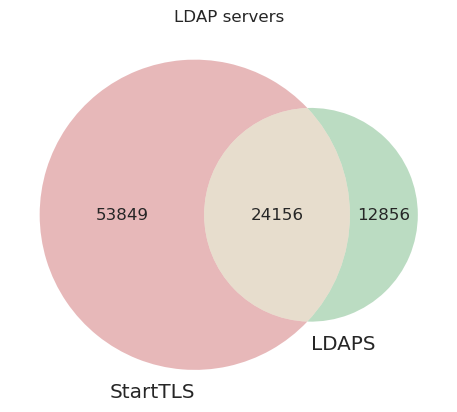

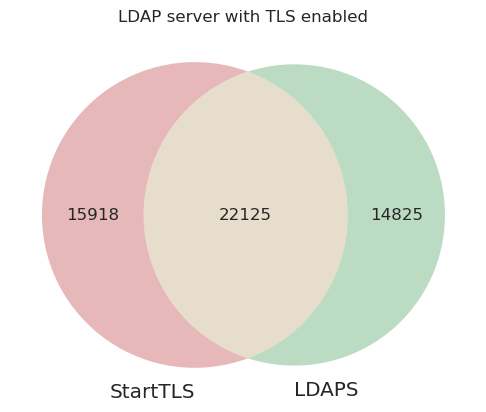

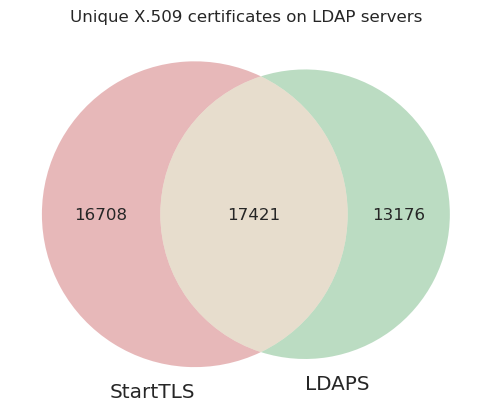

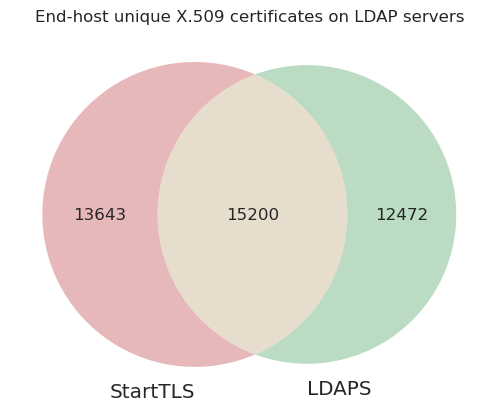

In [ ]:
from matplotlib_venn import venn2

_ = venn2(subsets=(cnt_stls_ldap, cnt_ldaps_ldap, cnt_inter_ldap), set_labels=('StartTLS', 'LDAPS'))
plt.title("LDAP servers")
plt.savefig("output/ldap_servers_overview.pdf", format='pdf')
plt.show()

_ = venn2(subsets=(cnt_stls_ldap_w_tls, cnt_ldaps_ldap_w_tls, cnt_inter_ldap_w_tls), set_labels=('StartTLS', 'LDAPS'))
plt.title("LDAP server with TLS enabled")
plt.savefig("output/ldap_servers_w_tls_overview.pdf", format='pdf')
plt.show()

# Unique X.509 from all certificates of LDAP servers (counting the chains)
_ = venn2(subsets=(cnt_stls_certs, cnt_ldaps_certs, cnt_inter_certs), set_labels=('StartTLS', 'LDAPS'))
plt.title("Unique X.509 certificates on LDAP servers")
plt.savefig("output/uniq_all_certs_overview.pdf", format='pdf')
plt.show()

_ = venn2(subsets=(cnt_stls_uniq_end_host_certs, cnt_ldaps_uniq_end_host_certs, cnt_inter_uniq_end_host_certs), set_labels=('StartTLS', 'LDAPS'))
plt.title("End-host unique X.509 certificates on LDAP servers")
plt.savefig("output/end_host_uniq_certs_overview.pdf", format='pdf')
plt.show()

Root DSE and Schema overview

In [ ]:
for port, ts in METADATA_PORT_SCANDATE_MAP.items():
    print(port, ts)
    print("schema")
    schema_df = load_ldap_schema(port, ts)

    print("percentage of IPs without attributes", 100 *
    schema_df.filter(
        (psf.col("attribute_names") == psf.lit([]))
        | (psf.col("attribute_names") == psf.lit([[]]))
        ).count() / schema_df.count()
    )

    print("root dse")
    root_dse_df = load_ldap_root_dse(port, ts)
    print("percentage of IPs without attributes", 100 *
    root_dse_df.filter(
        (psf.col("attribute_names") == psf.lit([]))
        | (psf.col("attribute_names") == psf.lit([[]]))
        ).count() / root_dse_df.count()
    )

636 2024-04-23 00:00:00
schema
percentage of IPs without attributes 69.17579481699171
root dse
percentage of IPs without attributes 3.780390061448036
389 2024-04-24 00:00:00
schema
percentage of IPs without attributes 59.90987794493329
root dse
percentage of IPs without attributes 7.440391711609424


In [ ]:
#metadata_timestamp = tuple(METADATA_PORT_SCANDATE_MAP.values())
for port, ts in METADATA_PORT_SCANDATE_MAP.items():
    print(port, ts)
    _hosts_df = load_hosts_data(port, ts).select(psf.col("ip").alias("host_ip"))
    _schema_df = load_ldap_schema(port, ts)
    _schema_df = _schema_df.filter(
        (psf.col("attribute_names") != psf.lit([]))
        & (psf.col("attribute_names") != psf.lit([[]]))
    ).select(psf.col("ip").alias("schema_ip"))
    _hosts_schema_df = _hosts_df.join(_schema_df, _hosts_df.host_ip == _schema_df.schema_ip, "inner").filter(psf.col("schema_ip").isNotNull()).select("host_ip")

    _root_dse_df = load_ldap_root_dse(port, ts).select(psf.col("ip"))
    _root_dse_df = _root_dse_df.filter(
        (psf.col("attribute_names") != psf.lit([]))
        & (psf.col("attribute_names") != psf.lit([[]]))
    ).select(psf.col("ip").alias("root_dse_ip"))
    _hosts_root_dse_df = _hosts_df.join(_root_dse_df, _hosts_df.host_ip == _root_dse_df.root_dse_ip, "inner").filter(psf.col("root_dse_ip").isNotNull()).select("host_ip")

    _ips = _hosts_schema_df.unionByName(_hosts_root_dse_df)
    print(_ips.distinct().count())


636 2024-04-23 00:00:00
28859
389 2024-04-24 00:00:00
52241


### Extract certificates for FastGCD analysis

In [ ]:
from cryptography import x509
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.asymmetric import rsa

import pyspark.sql.types as pst


def get_moduli_from_pem(pem: str) -> str:
    try:
        cert = x509.load_pem_x509_certificate(str.encode(pem), default_backend())
    except ValueError:
        # the certificate contains bytes that cannot be interpreted. Probably invalid cert
        # https://github.com/pyca/cryptography/issues/6804
        return ""

    public_key = cert.public_key()
    if isinstance(public_key, rsa.RSAPublicKey):
        # remove 0x from hex, L if there is a L of Long Number and any unecessary left 0
        moduli = hex(public_key.public_numbers().n).lstrip("0x").rstrip("L").lstrip("0")
        return moduli

    return ""


get_moduli_udf = psf.udf(get_moduli_from_pem, pst.StringType())

In [ ]:
goscanner_df.select("ipv4", "port", "date", "cert").coalesce(1).write.csv("../dataset/processing/2023-Nov-ip_port_ts_cert")

### Selecting a snapshot

In [222]:
print(chosen_snapshot)
ts1, ts2 = chosen_snapshot
print(goscanner_df.count())
goscanner_df = goscanner_df.filter(
    (psf.col("date") == ts1)
    | (psf.col("date") == ts2)
)
print(goscanner_df.count())

print(goscanner_certs_df.count())
goscanner_certs_df = goscanner_certs_df.filter(
    (psf.col("date") == ts1)
    | (psf.col("date") == ts2)
)
print(goscanner_certs_df.count())

(datetime.datetime(2023, 11, 14, 0, 0), datetime.datetime(2023, 11, 15, 0, 0))
299934
74993
299934
74993


### X.509 analysis

In [ ]:
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import padding, rsa, ec
from cryptography.exceptions import InvalidSignature


# Self-signed, self-issued and cross certificates:
# https://datatracker.ietf.org/doc/html/rfc5280#section-3.2  
# "Self-signed certificates are used to convey a public key for use to begin certification paths.
# End entity certificates are issued to subjects that are not authorized to issue certificates."  
def is_self_signed(pem):
    """
    Checks if an X.509 certificate is self-signed based on signature verification.
    From Handbook of Applied Cryptography:
    "A public-key certificate consists of a data part and a signature part.
    The data part consists of the name of an entity, the public key corresponding to that entity..."
    "The signature part consists of the signature of a  TTP over the data part."
    TTP = Trusted third party
    Args:
        cert_pem: PEM encoded certificate data.

    Returns:
        True if the certificate appears to be self-signed, False otherwise or cannot be determined.
    """
    try:
        cert = x509.load_pem_x509_certificate(str.encode(pem), default_backend())
    except ValueError:
        return False

    # to be signed; raw certificate data
    tbs_certificate = cert.tbs_certificate_bytes
    public_key = cert.public_key()
    if cert.signature_hash_algorithm is None:
        return False
    signature_algorithm = cert.signature_hash_algorithm.name
    signature_value = cert.signature

    if signature_algorithm == hashes.SHA256().name:
        hasher = hashes.SHA256()
    elif signature_algorithm == hashes.SHA384().name:
        hasher = hashes.SHA384()
    elif signature_algorithm == hashes.SHA512().name:
        hasher = hashes.SHA512()
    elif signature_algorithm == hashes.SHA1().name:
        hasher = hashes.SHA1()
    elif signature_algorithm == hashes.MD5().name:
        hasher = hashes.MD5()
    else:
        raise NotImplementedError(f"{signature_algorithm} - Unsupported signature algorithm")

    # verify whether the public key signed the tbs_cert and hashed, matching the signature value
    try:
        if isinstance(public_key, rsa.RSAPublicKey):
            # https://cryptography.io/en/latest/hazmat/primitives/asymmetric/rsa/#cryptography.hazmat.primitives.asymmetric.padding.PKCS1v15
            # "It is not recommended that PKCS1v15 be used for new applications, 
            # OAEP should be preferred for encryption and PSS should be preferred for signatures."
            try:
                public_key.verify(
                        data=tbs_certificate,
                        signature=signature_value,
                        padding=padding.PSS(mgf=padding.MGF1(hasher), salt_length=padding.PSS.AUTO),
                        algorithm=hasher)
            except InvalidSignature:
                public_key.verify(
                        data=tbs_certificate,
                        signature=signature_value,
                        padding=padding.PKCS1v15(),
                        algorithm=hasher)
        elif isinstance(public_key, ec.EllipticCurvePublicKey):
            # no padding needed (not mentioned in the website)
            # https://cryptography.io/en/latest/hazmat/primitives/asymmetric/ec/
            public_key.verify(
                    signature=signature_value,
                    data=tbs_certificate,
                    signature_algorithm=ec.ECDSA(hasher))
        else:
            raise NotImplementedError(f"{type(public_key)} - Unsupported public key type")
        return True
    except InvalidSignature:
        return False


is_self_signed_udf = psf.udf(is_self_signed, pst.BooleanType())

#stls
#+-------------------------+-----+-------------------+
#|tls_signature_self_signed|count|            percent|
#+-------------------------+-----+-------------------+
#|                    false|10881|  81.73214151581162|
#|                 pkcs1v15| 2405| 18.065049200030046|
#|                      ecc|   27|0.20280928415834146|
#+-------------------------+-----+-------------------+
#ldaps
#+-------------------------+-----+--------------------+
#|tls_signature_self_signed|count|             percent|
#+-------------------------+-----+--------------------+
#|                    false|64698|   92.07844699988614|
#|                 pkcs1v15| 5550|   7.898781737447341|
#|                      ecc|   16|0.022771262666514858|
#+-------------------------+-----+--------------------+
#intersection
#+-------------------------+-----+------------------+
#|tls_signature_self_signed|count|           percent|
#+-------------------------+-----+------------------+
#|                    false|13865|  66.0175221407485|
#|                 pkcs1v15| 7119| 33.89677173602514|
#|                      ecc|   18|0.0857061232263594|
#+-------------------------+-----+------------------+
#No 'something else' in the rsa keys (and oaep is not supported by this verify backend)

#### Chain errors

In [231]:
starttls_cert_val_df = goscanner_df.filter(psf.col("port") == 389) \
                                 .dropDuplicates(["ipv4"]) \
                                 .select("ipv4", "chain_error", "cert")
ldaps_cert_val_df = goscanner_df.filter(psf.col("port") == 636) \
                               .dropDuplicates(["ipv4"]) \
                               .select("ipv4", "chain_error", "cert")


# starttls only
starttls_only_df = starttls_cert_val_df.select("ipv4").subtract(ldaps_cert_val_df.select("ipv4")).join(
    goscanner_df, "ipv4", "inner"
)
print(starttls_only_df.count())

# ldaps only
ldaps_only_df = ldaps_cert_val_df.select("ipv4").subtract(starttls_cert_val_df.select("ipv4")).join(
    goscanner_df, "ipv4", "inner"
)
print(ldaps_only_df.count())

inter_hosts_df = starttls_cert_val_df.join(
    ldaps_cert_val_df.withColumnRenamed(
        "chain_error", "a"
    ).withColumnRenamed("cert", "b"),
    "ipv4", "inner"
).drop("a").drop("b").withColumnRenamed(
    "cert", "a"
).withColumnRenamed(
    "chain_error", "b"
).join(
    goscanner_df, "ipv4", "inner"
).filter(psf.col("ipv4").isNotNull()).dropDuplicates(["ipv4"]).drop("a").drop("b")
print(inter_hosts_df.count())

15918
14825
22125


#### Self-signed certificates

In [ ]:
def show_self_signed(df):
    df.filter(
        psf.col("chain_error") == SHORT1  # signed by unknown authority
    ).withColumn(
        "tls_signature_self_signed", is_self_signed_udf(psf.col("cert"))
    ).groupby("tls_signature_self_signed").count(
    ).withColumn(
        'percent', psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy())
    ).sort("count", ascending=False).show()


show_self_signed(starttls_only_df)
show_self_signed(ldaps_only_df)
show_self_signed(inter_hosts_df)

+-------------------------+-----+------------------+
|tls_signature_self_signed|count|           percent|
+-------------------------+-----+------------------+
|                    false| 8261| 88.18317677198975|
|                     true| 1107|11.816823228010248|
+-------------------------+-----+------------------+

+-------------------------+-----+------------------+
|tls_signature_self_signed|count|           percent|
+-------------------------+-----+------------------+
|                    false| 8606| 85.75984055804683|
|                     true| 1429|14.240159441953164|
+-------------------------+-----+------------------+

+-------------------------+-----+------------------+
|tls_signature_self_signed|count|           percent|
+-------------------------+-----+------------------+
|                    false|10467| 79.94348124952265|
|                     true| 2626|20.056518750477355|
+-------------------------+-----+------------------+



In [ ]:
def cert_val_table(df):
    total = df.count()
    pdf = df.groupBy("chain_error").count().pandas_api()
    pdf["percentage"] = pdf["count"] / total * 100
    print("total: ", total)
    print(pdf.to_latex(index=False))
    display(pdf)

cert_val_table(starttls_only_df)
cert_val_table(ldaps_only_df)
cert_val_table(inter_hosts_df)

total:  15918


/usr/local/spark/python/pyspark/pandas/frame.py:2606: FutureWarning: Argument `col_space` will be removed in 4.0.0.
  warnings.warn(


\begin{tabular}{lrr}
\toprule
chain_error & count & percentage \\
\midrule
Signed by unknown authority & 9368 & 58.851615 \\
Invalid signature & 46 & 0.288981 \\
Not authorized to sign other certificates & 21 & 0.131926 \\
Valid chain & 3009 & 18.903129 \\
Expired/Not yet valid & 3474 & 21.824350 \\
\bottomrule
\end{tabular}



,chain_error,count,percentage
0,Signed by unknown authority,9368,58.851615
1,Invalid signature,46,0.288981
2,Not authorized to sign other certificates,21,0.131926
3,Valid chain,3009,18.903129
4,Expired/Not yet valid,3474,21.824350


total:  14825


/usr/local/spark/python/pyspark/pandas/frame.py:2606: FutureWarning: Argument `col_space` will be removed in 4.0.0.
  warnings.warn(


\begin{tabular}{lrr}
\toprule
chain_error & count & percentage \\
\midrule
Signed by unknown authority & 10035 & 67.689713 \\
Invalid signature & 3 & 0.020236 \\
Not authorized to sign other certificates & 7 & 0.047218 \\
Too many intermediate certificates & 1 & 0.006745 \\
Valid chain & 3078 & 20.762226 \\
Unhandled critical extension & 4 & 0.026981 \\
Expired/Not yet valid & 1697 & 11.446880 \\
\bottomrule
\end{tabular}



,chain_error,count,percentage
0,Signed by unknown authority,10035,67.689713
1,Invalid signature,3,0.020236
2,Not authorized to sign other certificates,7,0.047218
3,Too many intermediate certificates,1,0.006745
4,Valid chain,3078,20.762226
5,Unhandled critical extension,4,0.026981
6,Expired/Not yet valid,1697,11.446880


total:  22125


/usr/local/spark/python/pyspark/pandas/frame.py:2606: FutureWarning: Argument `col_space` will be removed in 4.0.0.
  warnings.warn(


\begin{tabular}{lrr}
\toprule
chain_error & count & percentage \\
\midrule
Signed by unknown authority & 13111 & 59.258757 \\
Invalid signature & 7 & 0.031638 \\
Not authorized to sign other certificates & 3 & 0.013559 \\
Valid chain & 3453 & 15.606780 \\
Unhandled critical extension & 5 & 0.022599 \\
Expired/Not yet valid & 5546 & 25.066667 \\
\bottomrule
\end{tabular}



,chain_error,count,percentage
0,Signed by unknown authority,13111,59.258757
1,Invalid signature,7,0.031638
2,Not authorized to sign other certificates,3,0.013559
3,Valid chain,3453,15.606780
4,Unhandled critical extension,5,0.022599
5,Expired/Not yet valid,5546,25.066667


X.509 version on end-host certificates

In [ ]:
print("StartTLS only")
starttls_only_df.groupBy("version").count().show()
print("LDAPS only")
ldaps_only_df.groupBy("version").count().show()
print("Intersection")
inter_hosts_df.groupBy("version").count().show()

StartTLS only
+-------+-----+
|version|count|
+-------+-----+
|   NULL|    1|
|     v1|  232|
|     v3|15685|
+-------+-----+

LDAPS only
+-------+-----+
|version|count|
+-------+-----+
|   NULL|  193|
|     v1|  229|
|     v3|14403|
+-------+-----+

Intersection
+-------+-----+
|version|count|
+-------+-----+
|   NULL|    1|
|     v1|  731|
|     v3|21393|
+-------+-----+



#### Common Names in X.509 certs

In [ ]:
# https://ccadb.my.salesforce-sites.com/mozilla/IncludedCACertificateReportCSVFormat
ca_pdf = pd.read_csv("../dataset/processing/IncludedCACertificateReport.csv")
# https://ccadb.my.salesforce-sites.com/mozilla/IntermediateCertsSeparateAuditsCSV
intermediate_pdf = pd.read_csv("../dataset/processing/IntermediateCertsSeparateAuditsCSV.csv")


def get_x509_name(dn_list, fingerprint):
    # e.g.:
    # dn_list=[C=US, O=Let's Encrypt, CN=R3]
    # dn_list=[C=BE, O=GlobalSign nv-sa, CN=GlobalSign Atlas R3 DV TLS CA 2023 Q3]
    name = None

    ca = ca_pdf[ca_pdf["SHA-256 Fingerprint"].str.contains(str(fingerprint), case=False) == True]["Owner"]
    if not ca.empty:
        name = ca.iloc[0]
    if name is None:
        inter = intermediate_pdf[intermediate_pdf["SHA-256 Fingerprint"].str.contains(str(fingerprint), case=False) == True]["Certificate Name"]
        if not inter.empty:
            name = inter.iloc[0]

    if dn_list:
        if name is None:
            for dn in dn_list:
                if "CN=" in dn:
                    name = dn.split("=")[-1]
                    break
        # group without CN
        if name is None:
            for dn in dn_list:
                if "O=" in dn:
                    name = dn.split("=")[-1]
                    break

        if name is None:
            for dn in dn_list:
                if "OU=" in dn:
                    name = dn.split("=")[-1]
                    break

    return name


get_x509_name_udf = psf.udf(get_x509_name, pst.StringType())

In [204]:
def subject_issuer_to_df(df):
    df = df.withColumn("subject", get_x509_name_udf(psf.col("subject_rdns"), psf.col("fingerprint")))
    return df.withColumn("issuer", get_x509_name_udf(psf.col("issuer_rdns"), psf.col("fingerprint")))


starttls_only_df = subject_issuer_to_df(starttls_only_df)
ldaps_only_df = subject_issuer_to_df(ldaps_only_df)
inter_hosts_df = subject_issuer_to_df(inter_hosts_df)
goscanner_df = subject_issuer_to_df(goscanner_df)

In [ ]:
# FILTER BY INVALID CHAINS
def show_x509_subject(df):
    _df = df.filter(
        psf.col("chain_error") != SHORT8
    ).groupBy("subject").count().withColumn(
        'percent', psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy())
    ).sort("percent", ascending=False)
    print("sum all count", _df.groupBy().sum().collect()[0][0])
    _df.show(truncate=False)


show_x509_subject(starttls_only_df)
show_x509_subject(ldaps_only_df)
show_x509_subject(inter_hosts_df)

sum all count 12909
+-------------------------------------+-----+-------------------+
|subject                              |count|percent            |
+-------------------------------------+-----+-------------------+
|Philip Newman                        |574  |4.446510186691455  |
|NULL                                 |232  |1.7971957548996824 |
|127.0.0.1                            |182  |1.4098690835850958 |
|localhost                            |157  |1.2162057479278023 |
|master14.tempo.arapbx.fr             |100  |0.7746533426291734 |
|synology.com                         |80   |0.6197226741033388 |
|PACS_J4C                             |75   |0.5809900069718801 |
|(none)                               |71   |0.5500038732667132 |
|dcm4che                              |58   |0.4492989387249206 |
|dom                                  |55   |0.4260593384460454 |
|synology                             |53   |0.41056627159346193|
|qhutm-jenkins-ci-64bit               |46   |0.356340537

In [ ]:
# FILTER BY VALID CHAINS
def all_uniq_end_host_certs_subject():
    _df = goscanner_df.dropDuplicates(["cert"]).groupBy(
        "ipv4"
    ).agg(
        psf.collect_set("subject").alias("subjects"),
        psf.collect_set("chain_error").alias("chain_errors")
    ).filter(
        psf.array_contains(psf.col("chain_errors"), SHORT8)
    ).groupBy("subjects").count().withColumn(
        'percent', psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy())
    )
    print("sum all count", _df.groupBy().sum().collect()[0][0])
    _df.sort("percent", ascending=False).show(truncate=False)


all_uniq_end_host_certs_subject()

sum all count 6917
+--------------------------+-----+--------------------+
|subjects                  |count|percent             |
+--------------------------+-----+--------------------+
|[*.ptcmscloud.com]        |49   |0.7083995952002313  |
|[*.ptcmsdev.com]          |41   |0.5927425184328466  |
|[*.gammaapi.net]          |8    |0.11565707676738471 |
|[ads.case.edu]            |6    |0.08674280757553852 |
|[*.wolfconnect.com]       |4    |0.057828538383692354|
|[*.staging.ptcmscloud.com]|4    |0.057828538383692354|
|[*.ozone.octogate.de]     |3    |0.04337140378776926 |
|[*.hksyu.edu]             |3    |0.04337140378776926 |
|[*.trustedpath.info]      |3    |0.04337140378776926 |
|[*.prod.cloud.8x8.com]    |3    |0.04337140378776926 |
|[*.mithiskyconnect.com]   |3    |0.04337140378776926 |
|[*.sip-ecotel.de]         |3    |0.04337140378776926 |
|[*.uni-sofia.bg]          |3    |0.04337140378776926 |
|[mail.reddawg.net]        |2    |0.028914269191846177|
|[*.dialpad.com]           |2

In [ ]:
def show_x509_issuer(df):
    _df = df.filter(
        psf.col("chain_error") == SHORT1
    ).groupBy("issuer").count().withColumn(
        'percent', psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy())
    ).sort("percent", ascending=False)
    # collect() = Row(sum(count)=X, sum(percent)=Y)
    print("sum all count", _df.groupBy().sum().collect()[0][0])
    _df.show(truncate=False)


show_x509_issuer(starttls_only_df)
show_x509_issuer(ldaps_only_df)
show_x509_issuer(inter_hosts_df)

sum all count 9368
+----------------------------------------------+-----+-------------------+
|issuer                                        |count|percent            |
+----------------------------------------------+-----+-------------------+
|R3                                            |3174 |33.88129803586678  |
|www.mail.org                                  |366  |3.906917164816396  |
|VPN                                           |167  |1.78266438941076   |
|Synology Inc. CA                              |129  |1.3770281810418445 |
|docker-light-baseimage                        |99   |1.0567890691716482 |
|Certificate Authority                         |71   |0.7578992314261315 |
|IHE Europe CA                                 |58   |0.6191289496157131 |
|Certum Domain Validation CA SHA2              |53   |0.5657557643040136 |
|ssp-sample-ssp-symantec-dir-ca                |40   |0.4269854824935952 |
|localhost                                     |31   |0.3309137489325363 |
|mx.nu

In [ ]:
# FILTER BY Signed by Unknown authority
def all_uniq_end_host_certs_issuer():
    _df = goscanner_df.dropDuplicates(["cert"]).groupBy(
        "ipv4"
    ).agg(
        psf.collect_set("issuer").alias("issuers"),
        psf.collect_set("chain_error").alias("chain_errors")
    ).filter(
        psf.array_contains(psf.col("chain_errors"), SHORT1)
    ).groupBy("issuers").count().withColumn(
        'percent', psf.lit(100) * psf.col('count') / psf.sum('count').over(Window.partitionBy())
    )
    print("sum all count", _df.groupBy().sum().collect()[0][0])
    _df.sort("percent", ascending=False).show(truncate=False)


all_uniq_end_host_certs_issuer()

sum all count 28529
+------------------------------------------------+-----+-------------------+
|issuers                                         |count|percent            |
+------------------------------------------------+-----+-------------------+
|[R3]                                            |7965 |27.918959655087804 |
|[CA]                                            |1239 |4.342949279680325  |
|[VPN]                                           |855  |2.9969504714501034 |
|[Certificate Authority]                         |745  |2.611377896175821  |
|[Synology Inc. CA]                              |567  |1.987451365277437  |
|[innovaphone]                                   |491  |1.7210557678152056 |
|[Go Daddy Secure Certificate Authority - G2]    |364  |1.2758947036348978 |
|[www.mail.org]                                  |350  |1.226821830418171  |
|[docker-light-baseimage]                        |165  |0.5783588629114235 |
|[Certum Domain Validation CA SHA2]              |145  |

In [ ]:
ms_issuer = "Microsoft Update Secure Server CA 1"
# I could not find this issuer

DataFrame[ipv4: string, fingerprint: string, not_valid_before: timestamp, not_valid_after: timestamp]

#### X.509 period validity

In [220]:
def get_validity_windows_years(not_before, not_after):
    if not_before is None or not_after is None:
        return 0
    window = round((not_after - not_before).days / 30 / 12)
    return window


def get_validity_windows_months(not_before, not_after):
    if not_before is None or not_after is None:
        return 0
    window = round((not_after - not_before).days / 30)
    return window


validity_window_years_udf = psf.udf(get_validity_windows_years, pst.IntegerType())
validity_window_months_udf = psf.udf(get_validity_windows_months, pst.IntegerType())


def get_validity(df):
    df = df.withColumn(
        "validity_window_years",
        validity_window_years_udf(psf.col("not_valid_before"),
                                psf.col("not_valid_after")
                                ))

    df = df.withColumn(
        "validity_window_months",
        validity_window_months_udf(psf.col("not_valid_before"),
                                psf.col("not_valid_after")
                                ))
    return df


# CDF plotting https://stackoverflow.com/questions/25577352/plotting-cdf-of-a-pandas-series-in-python

Dividing into StartTLS, LDAPS and Intersection of them

In [232]:
starttls_only_df = get_validity(starttls_only_df)
ldaps_only_df = get_validity(ldaps_only_df)
inter_hosts_df = get_validity(inter_hosts_df)

In [255]:
valid_starttls_only_pdf = starttls_only_df.filter(
    psf.col("chain_error") == SHORT8
).toPandas()
invalid_starttls_only_pdf = starttls_only_df.filter(
    psf.col("chain_error") != SHORT8
).toPandas()

valid_ldaps_only_pdf = ldaps_only_df.filter(
    psf.col("chain_error") == SHORT8
).toPandas()
invalid_ldaps_only_pdf = ldaps_only_df.filter(
    psf.col("chain_error") != SHORT8
).toPandas()

valid_inter_hosts_pdf = inter_hosts_df.filter(
    psf.col("chain_error") == SHORT8
).toPandas()
invalid_inter_hosts_pdf = inter_hosts_df.filter(
    psf.col("chain_error") != SHORT8
).toPandas()

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 9999-12-31 23:59:59, at position 1788

CDF Valid for chains

/usr/local/spark/python/pyspark/pandas/plot/matplotlib.py:859: FutureWarning: Argument `sort_columns` will be removed in 4.0.0.
  warnings.warn(


AttributeError: Line2D.set() got an unexpected keyword argument 'sort_columns'

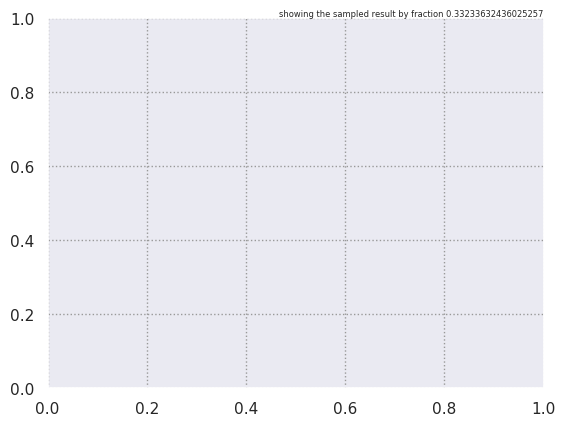

In [254]:
valid_starttls_only_pdf = valid_starttls_only_pdf.sort_values(by=['validity_window_months'])
valid_starttls_only_pdf['cdf'] = valid_starttls_only_pdf['validity_window_months'].cumsum() / valid_starttls_only_pdf['validity_window_months'].sum()

valid_ldaps_only_pdf = valid_ldaps_only_pdf.sort_values(by=['validity_window_months'])
valid_ldaps_only_pdf['cdf'] = valid_ldaps_only_pdf['validity_window_months'].cumsum() / valid_ldaps_only_pdf['validity_window_months'].sum()

valid_inter_hosts_pdf = valid_inter_hosts_pdf.sort_values(by=['validity_window_months'])
valid_inter_hosts_pdf['cdf'] = valid_inter_hosts_pdf['validity_window_months'].cumsum() / valid_inter_hosts_pdf['validity_window_months'].sum()

fig, ax1 = plt.subplots()

valid_starttls_only_pdf.plot(x='validity_window_months', y='cdf', ax=ax1, linewidth=2, color=sns.color_palette()[1], label='Valid chains on StartTLS', backend='matplotlib')  # color='red', 
valid_ldaps_only_pdf.plot(x='validity_window_months', y='cdf', ax=ax1, linewidth=2, color=sns.color_palette()[3], label='Valid chains LDAPS', backend='matplotlib')  # color='black', 
valid_inter_hosts_pdf.plot(x='validity_window_months', y='cdf', ax=ax1, linewidth=2, color=sns.color_palette()[3], label='Intersection of valid chains', backend='matplotlib')  # color='black', 

ax1.legend().set_visible(False)

ax1.set_title("Certificate validity CDF (2023)")
ax1.set_xlabel("Validity window on invalid chains (months)")
ax1.set_ylabel("CDF")
ax1.margins(x=0,y=0)
#ax1.set_xscale("log")
ax1.minorticks_on()
ax1.grid(True, which="minor")
ax1.grid(True, which="major")
fig.tight_layout()
handles, labels = ax1.get_legend_handles_labels()
new_handles = [mlines.Line2D([], [], c=h.get_color()) for h in handles]
fig.legend(handles=new_handles, labels=labels, loc="right", bbox_to_anchor=(0.95, 0.4))
fig.savefig(f"output/valid_chains_cert_validity_cdf.pdf", format="pdf", bbox_inches="tight")
fig.show()

Dividing by 389 and 636

In [223]:
goscanner_df = get_validity(goscanner_df)

window_invalid_stls_pdf = goscanner_df.filter(
    psf.col("port") == 389
).dropDuplicates(
    ["ipv4"]
).filter(
    psf.col("chain_error") != SHORT8
).select("validity_window_years").toPandas()

window_invalid_ldaps_pdf = goscanner_df.filter(
    psf.col("port") == 636
).dropDuplicates(
    ["ipv4"]
).filter(
    psf.col("chain_error") != SHORT8
).select("validity_window_years").toPandas()

window_valid_stls_pdf = goscanner_df.filter(
    psf.col("port") == 389
).dropDuplicates(
    ["ipv4"]
).filter(
    psf.col("chain_error") == SHORT8
).select("validity_window_months").toPandas()

window_valid_ldaps_pdf = goscanner_df.filter(
    psf.col("port") == 636
).dropDuplicates(
    ["ipv4"]
).filter(
    psf.col("chain_error") == SHORT8
).select("validity_window_months").toPandas()

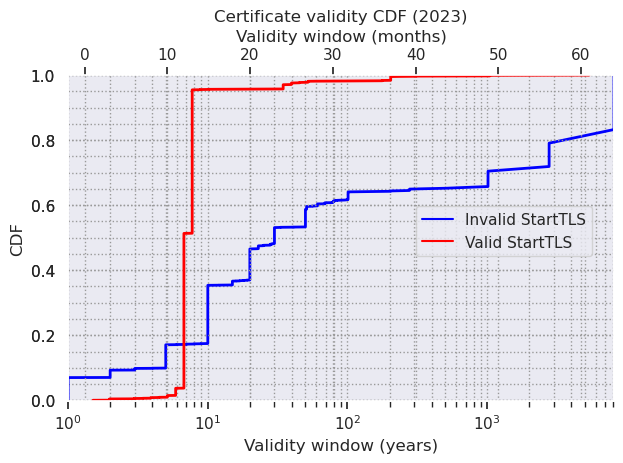

In [225]:
_window_invalid_stls_pdf = window_invalid_stls_pdf.sort_values(by=['validity_window_years'])
_window_invalid_stls_pdf['cdf'] = _window_invalid_stls_pdf['validity_window_years'].cumsum() / _window_invalid_stls_pdf['validity_window_years'].sum()

_window_valid_stls_pdf = window_valid_stls_pdf.sort_values(by=['validity_window_months'])
_window_valid_stls_pdf['cdf'] = _window_valid_stls_pdf['validity_window_months'].cumsum() / _window_valid_stls_pdf['validity_window_months'].sum()

fig, ax1 = plt.subplots()
ax2 = ax1.twiny()

# some attempts...
#x1 = np.sort(_window_invalid_stls_pdf['validity_window_years'])  #_window_invalid_stls_pdf['validity_window_years']
#y1 = np.arange(1, len(x1)+1) / len(x1) * 100  #_window_invalid_stls_pdf['cdf']
#ax1.plot(x1, y1, linewidth=2)
#ax1.hist(x, cumulative=True, density=1, bins=100)
#ax2.plot(_window_valid_stls_pdf['validity_window_months'], _window_valid_stls_pdf['cdf'], linewidth=2)

_window_invalid_stls_pdf.plot(x='validity_window_years', y='cdf', ax=ax1, linewidth=2, color='blue')
_window_valid_stls_pdf.plot(x='validity_window_months', y='cdf', ax=ax2, linewidth=2, color='red')

ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

ax1.set_title("Certificate validity CDF (2023)")
ax1.set_xlabel("Validity window (years)")
ax2.set_xlabel("Validity window (months)")
ax1.set_ylabel("CDF")
ax1.margins(x=0,y=0)
ax1.set_xscale("log")
ax1.minorticks_on()
ax1.grid(True, which="minor")
ax1.grid(True, which="major")
fig.tight_layout()
handles, labels = ax1.get_legend_handles_labels()
handles_tmp, labels_tmp = ax2.get_legend_handles_labels()
handles.extend(handles_tmp)
labels = ['Invalid StartTLS', 'Valid StartTLS']  #.extend(labels_tmp)
new_handles = [mlines.Line2D([], [], c=h.get_color()) for h in handles]
fig.legend(handles=new_handles, labels=labels, loc="right", bbox_to_anchor=(0.95, 0.5))
fig.savefig(f"output/validity_cdf_stls.pdf", format="pdf", bbox_inches="tight")
fig.show()

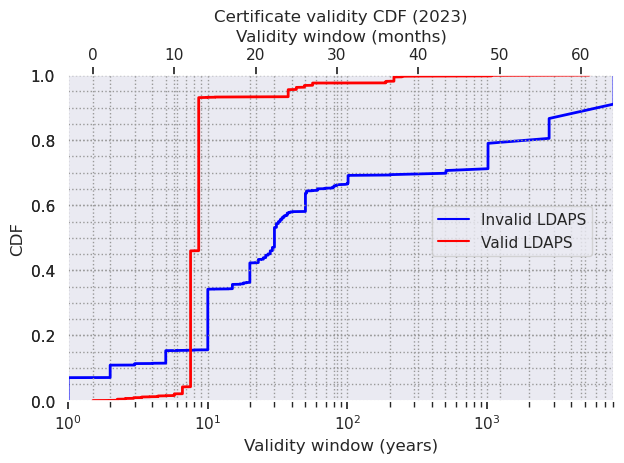

In [236]:
_window_invalid_ldaps_pdf = window_invalid_ldaps_pdf.sort_values(by=['validity_window_years'])
_window_invalid_ldaps_pdf['cdf'] = _window_invalid_ldaps_pdf['validity_window_years'].cumsum() / _window_invalid_ldaps_pdf['validity_window_years'].sum()

_window_valid_ldaps_pdf = window_valid_ldaps_pdf.sort_values(by=['validity_window_months'])
_window_valid_ldaps_pdf['cdf'] = _window_valid_ldaps_pdf['validity_window_months'].cumsum() / _window_valid_ldaps_pdf['validity_window_months'].sum()

fig, ax1 = plt.subplots()
ax2 = ax1.twiny()

_window_invalid_ldaps_pdf.plot(x='validity_window_years', y='cdf', ax=ax1, linewidth=2, color='blue')
_window_valid_ldaps_pdf.plot(x='validity_window_months', y='cdf', ax=ax2, linewidth=2, color='red')

ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

ax1.set_title("Certificate validity CDF (2023)")
ax1.set_xlabel("Validity window (years)")
ax2.set_xlabel("Validity window (months)")
ax1.set_ylabel("CDF")
ax1.margins(x=0,y=0)
ax1.set_xscale("log")
ax1.minorticks_on()
ax1.grid(True, which="minor")
ax1.grid(True, which="major")
fig.tight_layout()
handles, labels = ax1.get_legend_handles_labels()
handles_tmp, labels_tmp = ax2.get_legend_handles_labels()
handles.extend(handles_tmp)
labels = ['Invalid LDAPS', 'Valid LDAPS']  #.extend(labels_tmp)
new_handles = [mlines.Line2D([], [], c=h.get_color()) for h in handles]
fig.legend(handles=new_handles, labels=labels, loc="right", bbox_to_anchor=(0.95, 0.5))
fig.savefig(f"output/validity_cdf_ldaps.pdf", format="pdf", bbox_inches="tight")
fig.show()

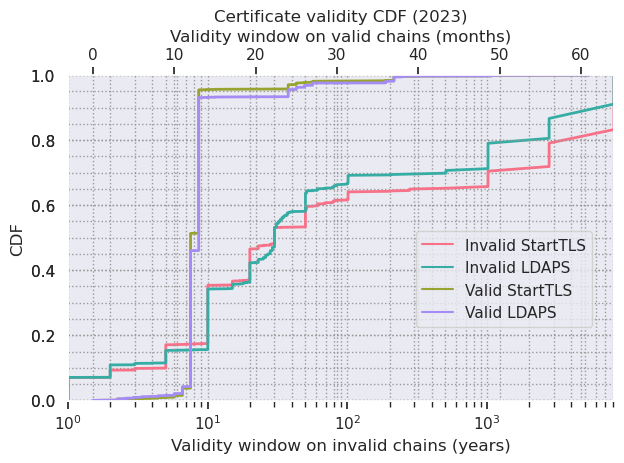

In [227]:
_window_invalid_stls_pdf = window_invalid_stls_pdf.sort_values(by=['validity_window_years'])
_window_invalid_stls_pdf['cdf'] = _window_invalid_stls_pdf['validity_window_years'].cumsum() / _window_invalid_stls_pdf['validity_window_years'].sum()

_window_valid_stls_pdf = window_valid_stls_pdf.sort_values(by=['validity_window_months'])
_window_valid_stls_pdf['cdf'] = _window_valid_stls_pdf['validity_window_months'].cumsum() / _window_valid_stls_pdf['validity_window_months'].sum()

_window_invalid_ldaps_pdf = window_invalid_ldaps_pdf.sort_values(by=['validity_window_years'])
_window_invalid_ldaps_pdf['cdf'] = _window_invalid_ldaps_pdf['validity_window_years'].cumsum() / _window_invalid_ldaps_pdf['validity_window_years'].sum()

_window_valid_ldaps_pdf = window_valid_ldaps_pdf.sort_values(by=['validity_window_months'])
_window_valid_ldaps_pdf['cdf'] = _window_valid_ldaps_pdf['validity_window_months'].cumsum() / _window_valid_ldaps_pdf['validity_window_months'].sum()

fig, ax1 = plt.subplots()
ax2 = ax1.twiny()

_window_invalid_stls_pdf.plot(x='validity_window_years', y='cdf', ax=ax1, linewidth=2, color=sns.color_palette()[0], label='Invalid StartTLS')  # color='blue', 
_window_valid_stls_pdf.plot(x='validity_window_months', y='cdf', ax=ax2, linewidth=2, color=sns.color_palette()[1], label='Valid StartTLS')  # color='red', 
_window_invalid_ldaps_pdf.plot(x='validity_window_years', y='cdf', ax=ax1, linewidth=2, color=sns.color_palette()[2], label='Invalid LDAPS')  # color='green', 
_window_valid_ldaps_pdf.plot(x='validity_window_months', y='cdf', ax=ax2, linewidth=2, color=sns.color_palette()[3], label='Valid LDAPS')  # color='black', 

ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

ax1.set_title("Certificate validity CDF (2023)")
ax1.set_xlabel("Validity window on invalid chains (years)")
ax2.set_xlabel("Validity window on valid chains (months)")
ax1.set_ylabel("CDF")
ax1.margins(x=0,y=0)
ax1.set_xscale("log")
ax1.minorticks_on()
ax1.grid(True, which="minor")
ax1.grid(True, which="major")
fig.tight_layout()
handles, labels = ax1.get_legend_handles_labels()
handles_tmp, labels_tmp = ax2.get_legend_handles_labels()
handles.extend(handles_tmp)
labels.extend(labels_tmp)
new_handles = [mlines.Line2D([], [], c=h.get_color()) for h in handles]
fig.legend(handles=new_handles, labels=labels, loc="right", bbox_to_anchor=(0.95, 0.4))
fig.savefig(f"output/validity_cdf.pdf", format="pdf", bbox_inches="tight")
fig.show()

### Hosts analysis

In [ ]:
def process_hosts(df, dataset: str):
    df.persist()

    print("Processing LDAP hosters")
    # ldap_hoster_pdf = df.select("ipv4", "date").toPandas().value_counts().reset_index()
    ldap_hoster_pdf = df.select("ipv4", "date").groupBy("date").count().coalesce(1).pandas_api()
    ldap_hoster_pdf.to_csv(f"../dataset/processing/{dataset}_date_ldap_hosts")
    #ldap_hoster_pdf.value_counts("date").to_csv(f"../dataset/processing/{dataset}_date_ldap_hosts")

    df.unpersist()

In [ ]:
print("Processing Censys CUIDS")
process_hosts(censys_df, "censys")

print("Processing GoScanner")
process_hosts(goscanner_df, "goscanner")

Processing Censys CUIDS
Processing LDAP hosters


/usr/local/spark/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Processing GoScanner
Processing LDAP hosters


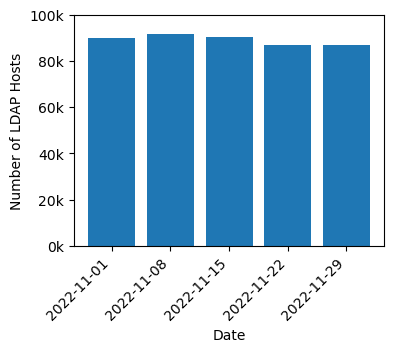

In [ ]:
# UNUSED
aggr_ldap_hoster_pdf = pd.concat([pd.read_csv(filename, parse_dates=True) for filename in glob("../dataset/processing/censys_date_ldap_hosts/*csv")])

fig, ax = plt.subplots(figsize=(4,3))  # Adjust the width and height as desired
ax.bar(aggr_ldap_hoster_pdf['date'], aggr_ldap_hoster_pdf['count'])
ax.set_xlabel('Date')
xlabels = [datetime.fromisoformat(label.get_text()).strftime('%Y-%m-%d') for label in ax.get_xticklabels()]
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, ha='right') 
# change y ticks to show in k
yticks = np.array([int(item.get_text()) for item in ax.get_yticklabels()])
ylabels = [f'{int(item.get_text())/1000:.0f}k' for item in ax.get_yticklabels()]
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
ax.set_ylabel('Number of LDAP Hosts')
fig.savefig("output/ldap_hosts.pdf", dpi=300, bbox_inches='tight')
fig.show()

Taking the average of LDAP hosts of a month of data:

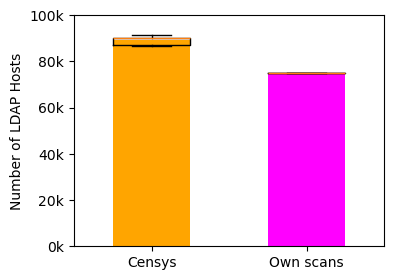

In [ ]:
censys_aggr_ldap_hoster_pdf = pd.concat([pd.read_csv(filename, parse_dates=True) for filename in glob("../dataset/processing/censys_date_ldap_hosts/*csv")])
goscanner_ldap_hoster_pdf = pd.concat([pd.read_csv(filename, parse_dates=True) for filename in glob("../dataset/processing/goscanner_date_ldap_hosts/*csv")]).sort_values("date").iloc[1:]  # removing first line that came from previous snapshot (not a 636-389 pair)
even = goscanner_ldap_hoster_pdf.iloc[1::2]  # port 636
odd = goscanner_ldap_hoster_pdf.iloc[::2]  # port 389
goscanner_aggr_ldap_hoster_pdf = even["count"].to_numpy() + odd["count"].to_numpy()

fig, ax = plt.subplots(figsize=(4,3))  # Adjust the width and height as desired
ax.bar([1, 2], [statistics.mean(censys_aggr_ldap_hoster_pdf['count']), statistics.mean(goscanner_aggr_ldap_hoster_pdf)], color=['orange', 'magenta'], width=0.5)
ax.boxplot([censys_aggr_ldap_hoster_pdf['count'], goscanner_aggr_ldap_hoster_pdf], positions=[1, 2], widths=0.5)
ax.set_xticks([1, 2])
ax.set_xticklabels(["Censys", "Own scans"])
ax.set_ylabel('Number of LDAP Hosts')
#ax.set_title('Average number of LDAP Hosts')
yticks = np.array([int(item.get_text()) for item in ax.get_yticklabels()])
ylabels = [f'{int(item.get_text())/1000:.0f}k' for item in ax.get_yticklabels()]
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
fig.savefig("output/ldap_hosts.pdf", dpi=300, bbox_inches='tight')
fig.show()

### TLS connection Analysis

In [ ]:
def process_tls(df, dataset: str):
    df.persist()

    print("Processing TLS versions")
    tls_versions_df = df.filter((psf.col("tls_version").isNotNull()) & (psf.col("tls_version") != "")).groupBy("tls_version").count()
    tls_version_pdf = tls_versions_df.coalesce(1).pandas_api().sort_values("tls_version", ascending=False)
    total = tls_version_pdf["count"].sum()
    tls_version_pdf["percentage"] = tls_version_pdf["count"] / total * 100
    tls_version_pdf.to_csv(f"../dataset/processing/{dataset}_tls_version", index=False)

    print("Processing Ciphersuites")
    ciphers_df = df.filter((psf.col("tls_cipher").isNotNull()) & (psf.col("tls_cipher") != "")).groupBy("tls_cipher").count()
    ciphers_pdf = ciphers_df.coalesce(1).pandas_api().sort_values("count", ascending=False)
    #aggr_ciphers_pdf = ciphers_pdf.groupby("tls_cipher").sum().reset_index().sort_values("count", ascending=False)
    total = ciphers_pdf["count"].sum()
    ciphers_pdf["percentage"] = ciphers_pdf["count"] / total * 100
    ciphers_pdf.to_csv(f"../dataset/processing/{dataset}_all_ciphers", index=False)

    print("Processing Signature algorithms")
    tls_sign_algo_df = df.filter((psf.col("tls_signature_algorithm").isNotNull()) & (psf.col("tls_signature_algorithm") != "")).groupBy("tls_signature_algorithm").count()
    tls_sign_algo_pdf = tls_sign_algo_df.coalesce(1).pandas_api().sort_values("count", ascending=False)
    #aggr_tls_sign_algo_pdf = tls_sign_algo_pdf.groupby("tls_signature_algorithm").sum().reset_index().sort_values("count", ascending=False)
    total = tls_sign_algo_pdf["count"].sum()
    tls_sign_algo_pdf["percentage"] = tls_sign_algo_pdf["count"] / total * 100
    tls_sign_algo_pdf.to_csv(f"../dataset/processing/{dataset}_tls_sign_algo", index=False)

    print("Processing Self-signed certificates")
    tls_self_signed_df = df.filter((psf.col("tls_signature_self_signed").isNotNull())).groupBy("tls_signature_self_signed").count()
    tls_self_signed_pdf = tls_self_signed_df.coalesce(1).pandas_api().sort_values("count", ascending=False)
    #aggr_tls_self_signed_pdf = tls_self_signed_pdf.groupby("tls_signature_self_signed").sum().sort_values("count", ascending=False)
    total = tls_self_signed_pdf["count"].sum()
    tls_self_signed_pdf["percentage"] = tls_self_signed_pdf["count"] / total * 100
    tls_self_signed_pdf.to_csv(f"../dataset/processing/{dataset}_tls_self_signed", index=False)

    if False:
        # unused rfc recommendation code...
        tls_df = df.filter(psf.col("pubkey_bit_size").isNotNull()) \
                   .filter((psf.col("tls_cipher").isNotNull()) & (psf.col("tls_cipher") != "")) \
                   .filter((psf.col("tls_version").isNotNull()) & (psf.col("tls_version") != "")) \
                   .groupBy("tls_cipher", "tls_version", "pubkey_bit_size", "date").count()
        tls_pdf = tls_df.toPandas().to_csv(f"../dataset/processing/{dataset}_tls.csv", index=False)

    df.unpersist()

In [ ]:
print("Processing Censys CUIDS")
process_tls(censys_df, "censys")

print("Processing GoScanner")
process_tls(goscanner_df, "goscanner")

Processing Censys CUIDS
Processing TLS versions


/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Processing Self-signed certificates


/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Processing GoScanner
Processing TLS versions


/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Processing Self-signed certificates


/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [ ]:
censys_aggr_tls_version_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/censys_tls_version/*csv")])
print("Censys")
display(censys_aggr_tls_version_pdf)
print("GoScanner")
goscanner_aggr_tls_version_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/goscanner_tls_version/*csv")])
display(goscanner_aggr_tls_version_pdf)

Censys


,tls_version,count,percentage
0,TLSv1_3,39162,29.066591
1,TLSv1_2,88980,66.042217
2,TLSv1_1,682,0.506190
3,TLSv1_0,5908,4.385001


GoScanner


,tls_version,count,percentage
0,TLSv1.3,121559,35.959307
1,TLSv1.2,203679,60.251859
2,TLSv1.1,900,0.266236
3,TLSv1.0,11908,3.522598


In [ ]:
print("Censys")
censys_aggr_ciphers_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/censys_all_ciphers/*csv")])
display(censys_aggr_ciphers_pdf.sort_values("tls_cipher", ascending=False))

print("GoScanner")
goscanner_aggr_ciphers_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/goscanner_all_ciphers/*csv")])
display(goscanner_aggr_ciphers_pdf.sort_values("tls_cipher", ascending=False))

Censys


,tls_cipher,count,percentage
9,TLS_RSA_WITH_AES_256_GCM_SHA384,2626,1.949054
12,TLS_RSA_WITH_AES_256_CBC_SHA,832,0.617522
2,TLS_RSA_WITH_AES_128_GCM_SHA256,18658,13.848232
7,TLS_RSA_WITH_AES_128_CBC_SHA,5028,3.731853
11,TLS_RSA_WITH_3DES_EDE_CBC_SHA,883,0.655375
6,TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256,5904,4.382032
0,TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384,32555,24.162782
4,TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA,15440,11.459787
5,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,12022,8.922899
10,TLS_ECDHE_RSA_WITH_AES_128_CBC_SHA,974,0.722917


GoScanner


,tls_cipher,count,percentage
9,TLS_RSA_WITH_AES_256_GCM_SHA384,3927,1.161676
13,TLS_RSA_WITH_AES_256_CBC_SHA,1323,0.391367
0,TLS_RSA_WITH_AES_128_GCM_SHA256,69831,20.657248
7,TLS_RSA_WITH_AES_128_CBC_SHA,10586,3.131526
12,TLS_RSA_WITH_3DES_EDE_CBC_SHA,1388,0.410595
8,TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256,10431,3.085675
1,TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384,69222,20.477095
4,TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA,27055,8.003349
5,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,18461,5.461091
10,TLS_ECDHE_RSA_WITH_AES_128_CBC_SHA,1860,0.550221


In [ ]:
# https://owasp.org/www-chapter-london/assets/slides/OWASPLondon20180125_TLSv1.3_Andy_Brodie.pdf
# TLSv1.3:
# key exchange: ECDHE, DHE, PSK and, PSK-DHE (PSK for resumption)
# authentication (digital signature - uses X.509 cert): RSA, EdDSA or ECDSA. (Rivest-Shamir-Addleman, Edwards-curve Digital Signature Algorithm, Elliptic Curve Digital Signature Algorithm)
# See also https://datatracker.ietf.org/doc/html/rfc8446#section-1 for authentication
cipher_mapping = {
    # 'cipher_name' : ('key_exchange', 'authentication', 'encryption', 'hash', 'weak')
    'TLS_CHACHA20_POLY1305_SHA256': ('(EC)DHE/PSK', 'RSA/ECDSA/EdDSA', 'CHACHA20_POLY1305', 'SHA256', False),
    'TLS_AES_256_GCM_SHA384': ('(EC)DHE/PSK','RSA/ECDSA/EdDSA','AES_256_GCM','SHA384', False),
    'TLS_AES_128_GCM_SHA256': ('(EC)DHE/PSK','RSA/ECDSA/EdDSA','AES_128_GCM','SHA256', False),

    'TLS_ECDHE_RSA_WITH_CHACHA20_POLY1305_SHA256': ('ECDHE','RSA','CHACHA20_POLY1305','SHA256', False),
    'TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256': ('ECDHE','RSA','AES_128_GCM','SHA256', False),
    'TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384': ('ECDHE','RSA','AES_256_GCM','SHA384', False),
    'TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256': ('ECDHE','ECDSA','AES_128_GCM','SHA256', False),
    'TLS_ECDHE_ECDSA_WITH_AES_256_GCM_SHA384': ('ECDHE','ECDSA','AES_256_GCM','SHA384', False),
    'TLS_ECDHE_ECDSA_WITH_CHACHA20_POLY1305_SHA256': ('ECDHE','ECDSA','CHACHA20_POLY1305','SHA256', False),

    'TLS_ECDHE_ECDSA_WITH_AES_128_CBC_SHA': ('ECDHE','ECDSA','AES_128_CBC','SHA', True),
    'TLS_ECDHE_ECDSA_WITH_AES_256_CBC_SHA': ('ECDHE','ECDSA','AES_256_CBC','SHA', True),
    'TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA': ('ECDHE','RSA','AES_256_CBC','SHA', True),
    'TLS_ECDHE_RSA_WITH_AES_128_CBC_SHA': ('ECDHE','RSA','AES_128_CBC','SHA', True),
    'TLS_ECDHE_RSA_WITH_3DES_EDE_CBC_SHA': ('ECDHE','RSA','3DES_EDE_CBC','SHA', True),
    'TLS_RSA_WITH_AES_128_GCM_SHA256': ('RSA','RSA','AES_128_GCM','SHA256', True),
    'TLS_RSA_WITH_AES_256_GCM_SHA384': ('RSA','RSA','AES_256_GCM','SHA384', True),
    'TLS_RSA_WITH_AES_256_CBC_SHA': ('RSA','RSA','AES_256_CBC','SHA', True),
    'TLS_RSA_WITH_AES_128_CBC_SHA': ('RSA','RSA','AES_128_CBC','SHA', True),
    'TLS_RSA_WITH_3DES_EDE_CBC_SHA': ('RSA','RSA','3DES_EDE_CBC','SHA', True),
    # Add more mappings for other non-standard cipher strings if needed
}

def parse_tls_cipher(pdf):
    cipher = pdf['tls_cipher']
    try:
        tls_key_exchange, tls_authentication, tls_encryption, tls_hash, tls_weak = cipher_mapping[cipher]
    except KeyError:
        print(f"Unknown cipher: {cipher}")
        raise
    pdf['cipher_key_exchange'] = tls_key_exchange
    pdf['cipher_authentication'] = tls_authentication
    pdf['cipher_encryption'] = tls_encryption
    pdf['cipher_hash'] = tls_hash
    pdf['cipher_weak'] = tls_weak
    return pdf

In [ ]:
def show_cipher_ks(aggr_ciphers_pdf):
    aggr_ciphers_pdf = aggr_ciphers_pdf.apply(parse_tls_cipher, axis=1)
    encryption_pdf = aggr_ciphers_pdf.groupby("cipher_encryption").sum().reset_index().sort_values("count", ascending=False)[["cipher_encryption", "count", "percentage"]]
    display(encryption_pdf)
    key_exchange_pdf = aggr_ciphers_pdf.groupby("cipher_key_exchange").sum().reset_index().sort_values("count", ascending=False)[["cipher_key_exchange", "count", "percentage"]]
    display(key_exchange_pdf)

# TODO call this function with different aggr_ciphers_pdf (censys and goscanner)
print("Censys")
show_cipher_ks(censys_aggr_ciphers_pdf)

print("GoScanner")
show_cipher_ks(goscanner_aggr_ciphers_pdf)

Censys


,cipher_encryption,count,percentage
4,AES_256_GCM,54911,40.755722
2,AES_128_GCM,34247,25.418609
5,CHACHA20_POLY1305,22417,16.638215
3,AES_256_CBC,16272,12.077309
1,AES_128_CBC,6002,4.454769
0,3DES_EDE_CBC,883,0.655375


,cipher_key_exchange,count,percentage
1,ECDHE,67543,50.131372
0,(EC)DHE/PSK,39162,29.066591
2,RSA,28027,20.802037


GoScanner


,cipher_encryption,count,percentage
4,AES_256_GCM,121081,35.817906
2,AES_128_GCM,106267,31.435663
5,CHACHA20_POLY1305,68486,20.259373
3,AES_256_CBC,28378,8.394716
1,AES_128_CBC,12446,3.681747
0,3DES_EDE_CBC,1388,0.410595


,cipher_key_exchange,count,percentage
1,ECDHE,129432,38.288280
0,(EC)DHE/PSK,121559,35.959307
2,RSA,87055,25.752412


In [ ]:
# SHA256-RSAPSS, RSASSA-PSS:
# https://www.cryptsoft.com/pkcs11doc/v230/group__SEC__11__1__17__PKCS____1__RSA__PSS__SIGNATURE__WITH__SHA__1____SHA__256____SHA__384__OR__SHA__512.html
# https://crypto.stackexchange.com/questions/58680/whats-the-difference-between-rsa-pss-pss-and-rsa-pss-rsae-schemes
# https://crypto.stackexchange.com/questions/48407/should-i-be-using-pkcs1-v1-5-or-pss-for-rsa-signatures
sign_algo_x509_to_censys = {
    "sha256WithRSAEncryption": "SHA256-RSA",
    "sha1WithRSAEncryption": "SHA1-RSA",
    "sha384WithRSAEncryption": "SHA384-RSA",
    "sha512WithRSAEncryption": "SHA512-RSA",
    "ecdsa-with-SHA384": "ECDSA-SHA384",
    "md5WithRSAEncryption": "MD5-RSA",
    "ecdsa-with-SHA256": "ECDSA-SHA256",
    "Unknown OID": "Unknown OID",
    "RSASSA-PSS": "SHA1-RSAPSS",
    "ecdsa-with-SHA512": "ECDSA-SHA512",
    "ecdsa-with-SHA1": "ECDSA-SHA1"
}

In [ ]:
# https://www.alvestrand.no/objectid/submissions/2.16.840.1.101.3.4.3.16.html
# 2.16.840.1.101.3.4.3.16 = SHA-3-512 with RSA Encryption
print("Censys")
censys_aggr_tls_sign_algo_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/censys_tls_sign_algo/*csv")])
display(censys_aggr_tls_sign_algo_pdf)
print("GoScanner")
goscanner_aggr_tls_sign_algo_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/goscanner_tls_sign_algo/*csv")])
goscanner_aggr_tls_sign_algo_pdf["mapped"] = goscanner_aggr_tls_sign_algo_pdf["tls_signature_algorithm"].map(sign_algo_x509_to_censys)
display(goscanner_aggr_tls_sign_algo_pdf[["mapped", "count", "percentage"]])


Censys


,tls_signature_algorithm,count,percentage
0,SHA256-RSA,103396,76.741977
1,SHA1-RSA,26559,19.712466
2,SHA384-RSA,1901,1.410949
3,SHA512-RSA,1263,0.937417
4,MD5-RSA,736,0.546270
5,ECDSA-SHA384,565,0.419351
6,ECDSA-SHA256,258,0.191491
7,SHA256-RSAPSS,24,0.017813
8,ECDSA-SHA512,20,0.014844
9,2.16.840.1.101.3.4.3.16,5,0.003711


GoScanner


,mapped,count,percentage
0,SHA256-RSA,256858,76.161136
1,SHA1-RSA,68139,20.203940
2,SHA384-RSA,4770,1.414356
3,SHA512-RSA,3140,0.931043
4,ECDSA-SHA384,2108,0.625044
5,MD5-RSA,1132,0.335650
6,ECDSA-SHA256,877,0.260040
7,Unknown OID,106,0.031430
8,SHA1-RSAPSS,99,0.029355
9,ECDSA-SHA512,19,0.005634


In [ ]:
print("Censys")
censys_aggr_tls_self_signed_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/censys_tls_self_signed/*csv")])
display(censys_aggr_tls_self_signed_pdf)
print("GoScanner")
goscanner_aggr_tls_self_signed_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/goscanner_tls_self_signed/*csv")])
display(goscanner_aggr_tls_self_signed_pdf)

Censys


,tls_signature_self_signed,count,percentage
0,False,104620,77.650447
1,True,30112,22.349553


GoScanner


,tls_signature_self_signed,count,percentage
0,False,229106,67.773617
1,True,108940,32.226383


What are the organizations that are fostering tlsv1.3?

In [ ]:
tlsv3_org_pdf = goscanner_df.filter(psf.col("tls_version") == "TLSv1.3").groupBy("org").count().sort("count", ascending=False).toPandas()

In [ ]:
total = tlsv3_org_pdf["count"].sum()
tlsv3_org_pdf["percentage"] = tlsv3_org_pdf["count"] / total * 100
display(tlsv3_org_pdf.head(10))

,org,count,percentage
0,"Amazon.com, Inc.",10352,8.516029
1,Hetzner Online GmbH,7244,5.959246
2,Iway AG,6028,4.958909
3,OVH SAS,5034,4.141199
4,Contabo GmbH,2180,1.793368
5,Deutsche Telekom AG,2039,1.677375
6,"Chunghwa Telecom Co., Ltd.",1646,1.354075
7,"DigitalOcean, LLC",1624,1.335977
8,netcup GmbH,1395,1.147591
9,"Akamai Technologies, Inc.",1286,1.057922


3400


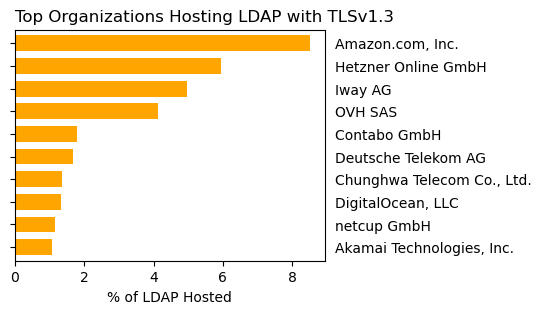

In [ ]:
print(len(tlsv3_org_pdf))
top_10tlsv3_org = tlsv3_org_pdf.head(10)[["org", "percentage"]].set_index("org")

width = 0.7
ax1 = top_10tlsv3_org.plot.barh(width=width, color=['orange'], figsize=(4,3), legend=False)
ax1.invert_yaxis()
ax1.set_title('Top Organizations Hosting LDAP with TLSv1.3', loc='left')
ax1.tick_params(axis='y', labelright=True, labelleft=False)  
ax1.set_xlabel('% of LDAP Hosted')
ax1.set_ylabel(None)
fig = ax1.get_figure()
fig.savefig("output/ldap_tlsv3_org.pdf", dpi=300, bbox_inches='tight')
fig.show()

In [ ]:
def show_total(aggr_tls_sign_algo_pdf, aggr_ciphers_pdf, aggr_tls_self_signed_pdf, aggr_tls_version_pdf):
    # all should match
    s = aggr_tls_sign_algo_pdf["count"].sum()
    c = aggr_ciphers_pdf["count"].sum()
    ss = aggr_tls_self_signed_pdf["count"].sum()
    t = aggr_tls_version_pdf["count"].sum()
    assert s == c == ss == t, f"sign_algo: {s}, ciphers: {c}, self_signed: {ss}, tls: {t}"
    print("Total hosts with TLS: ", aggr_tls_version_pdf["count"].sum())

print("Censys")
show_total(censys_aggr_tls_sign_algo_pdf, censys_aggr_ciphers_pdf, censys_aggr_tls_self_signed_pdf, censys_aggr_tls_version_pdf)
print("GoScanner")
show_total(goscanner_aggr_tls_sign_algo_pdf, goscanner_aggr_ciphers_pdf, goscanner_aggr_tls_self_signed_pdf, goscanner_aggr_tls_version_pdf)

Censys
Total hosts with TLS:  134732
GoScanner


AssertionError: sign_algo: 337256, ciphers: 338046, self_signed: 338046, tls: 338046

#### RFC-9325 recommendation - unused

In [ ]:
if False:
    aggr_tls_pdf = tls_pdf[["tls_cipher", "tls_version", "pubkey_bit_size"]].groupby(["tls_cipher", "tls_version", "pubkey_bit_size"]).agg('count').reset_index()
    aggr_tls_pdf["rfc9325"] = aggr_tls_pdf.apply(lambda x: rfc9325_recommendation(x['tls_cipher'], x['tls_version'], x['pubkey_bit_size']), axis=1)
    display(aggr_tls_pdf)
    aggr_tls_pdf.to_csv("../dataset/censys/processing/censys_tls.csv")


,tls_cipher,tls_version,pubkey_bit_size,rfc9325
0,TLS_AES_128_GCM_SHA256,TLSv1_3,256,Y
1,TLS_AES_128_GCM_SHA256,TLSv1_3,384,Y
2,TLS_AES_128_GCM_SHA256,TLSv1_3,2048,Y
3,TLS_AES_128_GCM_SHA256,TLSv1_3,4096,Y
4,TLS_AES_256_GCM_SHA384,TLSv1_3,256,Y
...,...,...,...,...
97,TLS_RSA_WITH_AES_256_CBC_SHA,TLSv1_2,4096,N
98,TLS_RSA_WITH_AES_256_GCM_SHA384,TLSv1_2,1024,N
99,TLS_RSA_WITH_AES_256_GCM_SHA384,TLSv1_2,2048,N
100,TLS_RSA_WITH_AES_256_GCM_SHA384,TLSv1_2,3072,N


### Types of LDAP servers

In [ ]:
# https://ldap.com/ldap-oid-reference-guide/
ldap_oid_pdf = pd.read_json("ldap_oid_dict.json")
# https://learn.microsoft.com/en-us/windows/win32/adschema/rootdse
ms_ad_oid_pdf = pd.read_json("ldap_ms_ad.json")
ms_ad_attr = [i.casefold() for i in ["isGlobalCatalogReady"]]

def decode_oid(oid):
    # decode with RFC
    # supportedFeatures, supportedControls,
    global ldap_oid_pdf
    global ms_ad_oid_pdf

    #if ms_ad_oid_pdf.get(oid, None) is not None:
    #    return "Microsoft Active Directory"

    if ldap_oid_pdf.get(oid, None) is None:
        return ""

    return ldap_oid_pdf[oid]["rfc"]


def _decode_oid(oid):
    # decode with description
    global ldap_oid_pdf

    if ldap_oid_pdf.get(oid, None) is None:
        return ""
    return ldap_oid_pdf[oid]["description"]


def decode_oids(oid_list: list):
    if oid_list is None:
        return []
    return [decode_oid(oid) for oid in oid_list]


decode_oids_udf = psf.udf(decode_oids, pst.StringType())


def get_server_name_by_dns(dns):
    # matchingRuleUse https://www.rfc-editor.org/rfc/rfc4512#section-4.1.4 https://www.rfc-editor.org/rfc/rfc4511#section-4.5.1.7.7
    # the filter item evaluates to TRUE if it matches at least one attribute type or subtype in the entry
    if dns is None:
        return ""
    if any('msExch'.lower() in s.lower() for s in dns):
        return "Microsot Exchange"
    return ""


def get_server_name(attribute_name: str, attribute_values: list) -> str:
    if attribute_name == None:
        return ""

    if "ibm-" in attribute_name:
        return "International Business Machines (IBM)"

    if attribute_name.casefold() in ms_ad_attr:
        return "Microsoft Active Directory"

    if attribute_name.casefold() == "vendorName".casefold() and attribute_values is not None and len(attribute_values) > 0:
        return attribute_values[0]

    if (attribute_name.casefold() == "supportedFeatures".casefold() or attribute_name.casefold() == "supportedControls".casefold()) and attribute_values is not None:
        for oid in attribute_values:
            decoded_oid = decode_oid(oid)
            if not fnmatch(decoded_oid, "RFC *") and decoded_oid != "" and " " in decoded_oid:
                return decoded_oid  # must be some server name, not RFC, not attribute
            if decoded_oid == "RFC 2307":
                return "Linux LDAP server"

    if attribute_name.casefold() == "namingContexts".casefold():
        return get_server_name_by_dns(attribute_values)

    return ""


get_server_name_udf = psf.udf(get_server_name, pst.StringType())

In [ ]:
for port, ts in METADATA_PORT_SCANDATE_MAP.items():
    print(port, ts)
    #schema_df = load_ldap_schema(port, ts)
    #schema_df = flatten_ldap_metadata(schema_df)

    root_dse_df = load_ldap_root_dse(port, ts)
    #root_dse_df = flatten_ldap_metadata(root_dse_df)

    break

636 2024-04-23 00:00:00


In [ ]:
flat_root_dse_df = flatten_ldap_metadata(root_dse_df)
flat_root_dse_df = flat_root_dse_df.withColumn("serverName", get_server_name_udf(psf.col("attribute_name"), psf.col("attribute_values_list")))
grouped_df = flat_root_dse_df.groupby("id", "ip", "port", "result_code", "error_data", "matched_dns").agg(
    psf.collect_set("serverName").alias("serverNames"),
    psf.collect_list("attribute_name").alias("attribute_names"),
    psf.collect_list("attribute_values_list")
    )

aggr_df = grouped_df.groupBy("serverNames").count().sort("count", ascending=False)
aggr_df = aggr_df.withColumn('percent', psf.lit(100)*psf.col('count')/psf.sum('count').over(Window.partitionBy()))
print(aggr_df.orderBy('percent', ascending=False).show(50, truncate=False))  #.pandas_api().to_latex(multirow=True, longtable=True, escape=False))
print(grouped_df.count())

+---------------------------------------------------------------------------+-----+---------------------+
|serverNames                                                                |count|percent              |
+---------------------------------------------------------------------------+-----+---------------------+
|[]                                                                         |16863|56.31512156024579    |
|[Microsoft Active Directory, ]                                             |9818 |32.787870691958325   |
|[389 Project, ]                                                            |1430 |4.775581084691424    |
|[Samba Team (https://www.samba.org), Microsoft Active Directory, ]         |737  |2.461261020571734    |
|[Apple, ]                                                                  |401  |1.3391664440288538   |
|[Microsoft Active Directory, Samba Team (http://samba.org), ]              |208  |0.6946299759551162   |
|[NetIQ Corporation, ]                        

In [ ]:
flat_root_dse_df = flatten_ldap_metadata(root_dse_df)
flat_root_dse_df = flat_root_dse_df.filter(
    (psf.col("attribute_name") == "supportedControl")
    | (psf.col("attribute_name") == "supportedcontrol")
).withColumn("decoded_oid", decode_oids_udf(psf.col("attribute_values_list")))

grouped_df = flat_root_dse_df.groupby("id", "ip", "port", "result_code", "error_data", "matched_dns").agg(
    psf.collect_list("attribute_name").alias("attribute_names"),
    psf.collect_list("attribute_values_list"),
    psf.collect_set("decoded_oid").alias("decoded_oids"),
    )

#flat_root_dse_df.groupBy("decoded_oid").count().sort("count", ascending=False).show(10, truncate=False)
#grouped_df.filter(psf.array_contains(psf.col("decoded_oids"), "iPlanet Directory Server")).show(10, truncate=False)
# no iplanet servers!

In [ ]:
flat_root_dse_df = flatten_ldap_metadata(root_dse_df)
flat_root_dse_df.filter(
    (psf.col("attribute_name") == "vendorName")
    | (psf.col("attribute_name") == "vendorname")
    | (psf.col("attribute_name") == "vendorVersion")
    | (psf.col("attribute_name") == "vendorversion")
).groupBy("attribute_values_list"
).count().sort("count", ascending=False).show(truncate=False)

flat_root_dse_df.filter(
    (psf.col("attribute_name") == "vendorName")
    | (psf.col("attribute_name") == "vendorname")
    | (psf.col("attribute_name") == "vendorVersion")
    | (psf.col("attribute_name") == "vendorversion")
).count()

+--------------+----------------------------------------+-----+
|attribute_name|attribute_values_list                   |count|
+--------------+----------------------------------------+-----+
|vendorName    |[389 Project]                           |446  |
|vendorName    |[Samba Team (https://www.samba.org)]    |254  |
|vendorName    |[Apple]                                 |154  |
|vendorName    |[Samba Team (http://samba.org)]         |82   |
|vendorVersion |[4.15.13]                               |70   |
|vendorVersion |[4.15.13-Ubuntu]                        |57   |
|vendorversion |NULL                                    |54   |
|vendorname    |NULL                                    |54   |
|vendorName    |[Apache Software Foundation]            |46   |
|vendorVersion |[510.30]                                |35   |
|vendorName    |[ForgeRock AS.]                         |33   |
|vendorVersion |[523.30.2]                              |33   |
|vendorVersion |[4.15.9]                

2365

### Country & Organizations

In [ ]:
# not required
#censys_df.select("ipv4").toPandas().to_csv("../dataset/censys/processing/censys_ldap_ips.csv", index=False)

In [ ]:
goscanner_df = goscanner_df.withColumn("country", ip_to_country_udf(psf.col("ipv4"), psf.col("date")))
goscanner_df = goscanner_df.withColumn("org", ip_to_org_udf(psf.col("ipv4"), psf.col("date")))

In [ ]:
def country_org_stats(df, dataset):
    df.persist()

    print("Processing Country")
    country_pdf = df.groupBy("country").count().sort(psf.col("count").desc()).pandas_api()
    total = country_pdf["count"].sum()
    country_pdf["percentage"] = country_pdf["count"] / total * 100
    country_pdf.to_csv(f"../dataset/processing/{dataset}_country", index=False)

    print("Processing Org")
    org_pdf = df.groupBy("org").count().sort(psf.col("count").desc()).pandas_api()
    total = org_pdf["count"].sum()
    org_pdf["percentage"] = org_pdf["count"] / total * 100
    org_pdf.to_csv(f"../dataset/processing/{dataset}_org", index=False)

    df.unpersist()

In [ ]:
print("Censys")
country_org_stats(censys_compact_df, "censys")
print("GoScanner")
country_org_stats(goscanner_df, "goscanner")

Censys


/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


GoScanner


/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Loading the saved data

In [ ]:
censys_country_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/censys_country/*csv")])
censys_org_pdf = pd.concat([pd.read_csv(filename, quotechar='"') for filename in glob("../dataset/processing/censys_org/*csv")])
goscanner_country_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/goscanner_country/*csv")])
goscanner_org_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/goscanner_org/*csv")])

In [ ]:
def see_unknown_org_cc(ccpdf, orgpdf):
    # ASN262726 at 20221101 does not give any country nor org name.
    # This ASN seems to be http://www.cortezonline.com.br (see https://www.ditatompel.com/asn/262726), https://bgp.he.net/AS262726
    # Some IPs do no have ASN
    # both cases we classified as Unknown
    aggr_country_pdf = ccpdf.groupby("country").sum().reset_index().sort_values("count", ascending=False)
    display(aggr_country_pdf[aggr_country_pdf["country"] == "Unknown"])

    aggr_org_pdf = orgpdf.groupby("org").sum().reset_index().sort_values("count", ascending=False)
    display(aggr_org_pdf[aggr_org_pdf["org"] == "Unknown"])


print("Censys")
see_unknown_org_cc(censys_country_pdf, censys_org_pdf)
print("GoScanner")
see_unknown_org_cc(goscanner_country_pdf, goscanner_org_pdf)

Censys


,country,count,percentage
191,Unknown,115,0.021156


,org,count,percentage
9052,Unknown,115,0.021156


GoScanner


,country,count,percentage
181,Unknown,1732,0.512356


,org,count,percentage
6336,Unknown,1732,0.512356


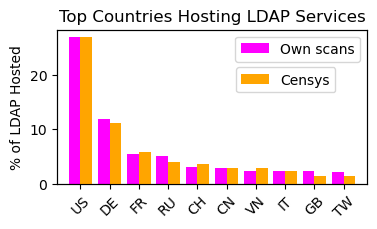

In [ ]:
top_10cc_goscanner = goscanner_country_pdf.head(10)["country"].to_list()
censys_top_country = censys_country_pdf[censys_country_pdf["country"].isin(top_10cc_goscanner)]

fig, ax1 = plt.subplots(figsize=(4,2))
ax2 = ax1.twinx()
width = 0.4
p1 = goscanner_country_pdf.head(10).percentage.plot(kind='bar', color='magenta', ax=ax1, width=width, position=1, align='center')
p2 = censys_top_country.percentage.plot(kind='bar', color='orange', ax=ax2, width=width, position=0, align='center')
ax1.set_ylabel('% of LDAP Hosted')
ax1.set_title('Top Countries Hosting LDAP Services')
ax1.tick_params(axis='x', rotation=45)
margin = (1 - width) + width / 2
ax1.set_xlim(-margin, len(top_10cc_goscanner) - 1 + margin)
ax2.set_xlim(-margin, len(top_10cc_goscanner) - 1 + margin)
ax1.set_xticklabels(top_10cc_goscanner)
ax2.set_yticks([])
ax2.set_yticklabels([])
p1.legend(['Own scans'], bbox_to_anchor=(1.0, 1.0))
p2.legend(['Censys'], bbox_to_anchor=(0.92, 0.8))
fig.savefig("output/ldap_country.pdf", dpi=300, bbox_inches='tight')
fig.show()

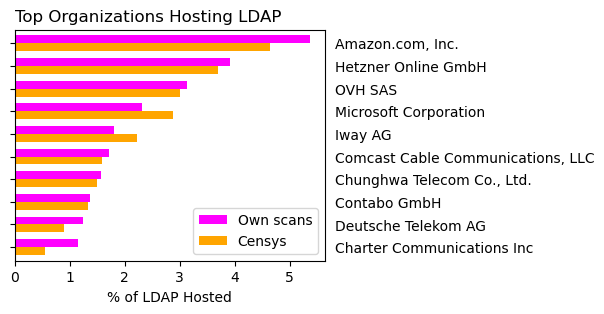

In [ ]:
top_10org_goscanner = goscanner_org_pdf.head(10)["org"].to_list()
censys_top_org = censys_org_pdf[censys_org_pdf["org"].isin(top_10org_goscanner)]
top_org_pdf = pd.DataFrame({
        "Own scans": goscanner_org_pdf.head(10)["percentage"].to_list(),
        "Censys": censys_top_org["percentage"].to_list(), 
     }, index=top_10org_goscanner)

width = 0.7
ax1 = top_org_pdf.plot.barh(width=width, color=['magenta', 'orange'], figsize=(4,3))
ax1.invert_yaxis()
ax1.set_title('Top Organizations Hosting LDAP', loc='left')
ax1.tick_params(axis='y', labelright=True, labelleft=False)  
ax1.set_xlabel('% of LDAP Hosted')
fig = ax1.get_figure()
fig.savefig("output/ldap_org.pdf", dpi=300, bbox_inches='tight')
fig.show()

#### Org from perspective of country

In [ ]:
def get_org_in_cc_dict(df, dataset):
    cc_cnt_dict = defaultdict(int)
    for item in [v.dropna().to_dict() for k,v in censys_country_pdf.iterrows()]:
        try:
            cc_cnt_dict[item["country"]] += item["count"]
        except KeyError:
            # unknown country
            pass

def country_percentage(country, count):
    if country == "NaN":
        return 0
    return count / cc_cnt_dict[country] * 100

org_country_outsourced_pdf["percentage"] = org_country_outsourced_pdf[["country", "count"]].apply(lambda x: country_percentage(*x), axis=1)
display(org_country_outsourced_pdf.head(10))

### DNS - CUIDS only

In [ ]:
def get_tld(domain):
    return tldextract.extract(domain).suffix

get_tld_udf = psf.udf(get_tld, pst.StringType())

censys_df.persist()
ldap_dns_df = censys_df.filter((psf.col("dns_name").isNotNull()) & (psf.col("dns_name") != ""))
ldap_dns_df = ldap_dns_df.withColumn("fdns_tlds", get_tld_udf(psf.col("dns_name")))

ldap_dns_pdf = ldap_dns_df.groupBy("fdns_tlds").count().sort(psf.col("count").desc()).pandas_api()
total = ldap_dns_pdf["count"].sum()
ldap_dns_pdf["percentage"] = ldap_dns_pdf["count"] / total * 100
ldap_dns_pdf.to_csv("../dataset/processing/censys_ldap_dns", index=False)
censys_df.unpersist()

NameError: name 'censys_df' is not defined

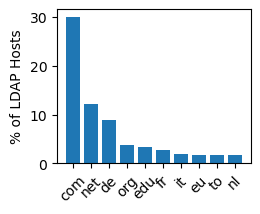

In [ ]:
ldap_dns_pdf = pd.concat([pd.read_csv(filename) for filename in glob("../dataset/processing/censys_ldap_dns/*csv")])

top_tlds = ldap_dns_pdf.head(10)
fig, ax = plt.subplots(figsize=(2.5,2))
ax.set_xticks(range(len(top_tlds["fdns_tlds"])))
ax.set_xticklabels(top_tlds["fdns_tlds"], rotation=45) 
#plt.yticks(rotation=0)
ax.bar(top_tlds['fdns_tlds'], top_tlds['percentage'])
ax.set_ylabel('% of LDAP Hosts')
#ax.set_xlabel('TLD')
#ax.set_title('% of LDAP Hosts\nper TLD - CUIDS')
fig.savefig("output/ldap_tld.pdf", dpi=300, bbox_inches='tight')
fig.show()

### Outsourcing analysis

In [ ]:
def method_1(leaf_cert_names, rdns_list, fdns_list):
#    varlist = [leaf_cert_names, rdns_list, fdns_list]
#    if rdns_list is not None and len(rdns_list) == 0:
#        x['r_dns_names'] = None
#    if fdns_list is not None and len(fdns_list) == 0:
#        x['dns_names'] = None

    # leaf_cert_names is a list of lists; hence, disentangle it
    flat_leaf_cert_names = []
    for lcn in leaf_cert_names:
        if lcn is not None:
            for name in lcn:
                flat_leaf_cert_names.append(name)

    leaf_cert_set = set(flat_leaf_cert_names) if flat_leaf_cert_names is not None else set()
    rdns_set = set(rdns_list) if rdns_list is not None else set()
    fdns_set = set(fdns_list) if fdns_list is not None else set()

    _x = leaf_cert_set
    _y = rdns_set.union(fdns_set)

    if len(_x) > 0:
        res_set_x = set()
        for item in _x:
            if item is None:
                continue
            extract = tldextract.extract(item)
            domain = extract.domain
            suffix = extract.suffix
            if domain != '' and suffix != '':
                sld_tld = f"{extract.domain}.{extract.suffix}"
                res_set_x.add(sld_tld)
        res_set_x = list(res_set_x) if len(res_set_x) > 0 else None
    else:
        res_set_x = None

    res_set_x = [item.lower() for item in res_set_x] if res_set_x is not None else None
    #x['x_set'] = res_set_x

    if len(_y) > 0:
        res_set_y = set()
        for item in _y:
            if item is None:
                continue
            extract = tldextract.extract(item)
            domain = extract.domain
            suffix = extract.suffix
            if domain != '' and suffix != '':
                sld_tld = f"{extract.domain}.{extract.suffix}"
                res_set_y.add(sld_tld)
        res_set_y = list(res_set_y) if len(res_set_y) > 0 else None
    else:
        res_set_y = None

    res_set_y = [item.lower() for item in res_set_y] if res_set_y is not None else None
    #x['y_set'] = res_set_y

    if res_set_y is not None and res_set_x is not None:
        len_set_x = len(res_set_x)
        counter = 0
        for item in res_set_x:
            if item in res_set_y:
                counter += 1
        outsourced = 'Outsource evidence' if counter != len_set_x else 'No outsource evidence'
        #x['outsourced_a'] = outsourced
    else:
        #x['outsourced_a'] = 'invalid'
        outsourced = 'Invalid'
    return outsourced


method_1_udf = psf.udf(method_1, pst.StringType())

In [ ]:
def method_2(rdns_names, fdns_names):
    if rdns_names is None:
        rdns_list = None
    else:
        rdns_set = set()
        for item in rdns_names:
            if item is None:
                continue
            extract = tldextract.extract(item)
            domain = extract.domain
            suffix = extract.suffix
            if domain != '' and suffix != '':
                sld_tld = f"{extract.domain}.{extract.suffix}"
                rdns_set.add(sld_tld)
        rdns_list = list(rdns_set) if len(rdns_set) > 0 else None

    if fdns_names is None:
        fdns_list = None
        fdns_tld_list = None
    else:
        fdns_set = set()
        fdns_tld_set = set()
        for item in fdns_names:
            if item is None:
                continue
            extract = tldextract.extract(item)
            domain = extract.domain
            suffix = extract.suffix
            if domain != '' and suffix != '':
                sld_tld = f"{extract.domain}.{extract.suffix}"
                fdns_set.add(sld_tld)
                fdns_tld_set.add(extract.suffix)
        fdns_list = list(fdns_set) if len(fdns_set) > 0 else None
        fdns_tld_list = list(fdns_tld_set) if len(fdns_tld_set) > 0 else None

    rdns_list = [item.lower() for item in rdns_list] if rdns_list is not None else None
    fdns_list = [item.lower() for item in fdns_list] if fdns_list is not None else None  
    #x['rdns_domains'] = rdns_list # =: x
    #x['fdns_domains'] = fdns_list # =: y
    #x['fdns_tlds'] = fdns_tld_list

    outsourced = 'Invalid'
    if rdns_list is not None and fdns_list is not None:
        target = len(rdns_list)
        counter = 0
        for item in rdns_list:
            if item in fdns_list:
                counter += 1
        if target == counter:
            fdns_list = set(fdns_list)
            rdns_list = set(rdns_list)
            res = fdns_list - rdns_list
            if len(res) > 0:
                #x['outsourced_b'] = True
                outsourced = 'Outsource evidence'
            else:
                #x['outsourced_b'] = False
                outsourced = 'No outsource evidence'
        else:
            #x['outsourced_b'] = True
            outsourced = 'Outsource evidence'
    else:
        #x['outsourced_b'] = 'invalid'
        outsourced = 'Invalid'

    return outsourced


method_2_udf = psf.udf(method_2, pst.StringType())

In [ ]:
censys_compact_df = censys_compact_df.withColumn("method_1", method_1_udf(psf.col("leaf_data_names"), psf.col("r_dns_names"), psf.col("dns_names")))
censys_compact_df = censys_compact_df.withColumn("method_2", method_2_udf(psf.col("r_dns_names"), psf.col("dns_names")))

In [ ]:
m1_pdf = censys_compact_df.groupBy("method_1").count().to_pandas_on_spark()
m2_pdf = censys_compact_df.groupBy("method_2").count().to_pandas_on_spark()

/usr/local/spark/python/pyspark/sql/dataframe.py:5719: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


In [ ]:
print("Applicability")
m1_total = m1_pdf["count"].sum()
m1_pdf["percentage"] = m1_pdf["count"] / m1_total * 100
display(m1_pdf)
m2_total = m2_pdf["count"].sum()
m2_pdf["percentage"] = m2_pdf["count"] / m2_total * 100
display(m2_pdf)
print(m2_total)

assert m1_total == m2_total

Applicability


,method_1,count,percentage
0,Outsource evidence,91626,16.856184
1,No outsource evidence,185545,34.134204
2,Invalid,266404,49.009612


,method_2,count,percentage
0,Outsource evidence,111235,20.463597
1,No outsource evidence,173643,31.944626
2,Invalid,258697,47.591777


543575


#### Outsourcing from perspective of country

In [ ]:
org_country_outsourced_pdf = censys_compact_df.filter((psf.col("method_1") == "Outsource evidence") | (psf.col("method_2") == "Outsource evidence")).groupBy(["org", "country"]).count().sort(psf.col("count").desc()).toPandas()

In [ ]:
cc_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in censys_country_pdf.iterrows()]:
    try:
        cc_cnt_dict[item["country"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def country_percentage(country, count):
    if country == "NaN":
        return 0
    return count / cc_cnt_dict[country] * 100

org_country_outsourced_pdf["percentage"] = org_country_outsourced_pdf[["country", "count"]].apply(lambda x: country_percentage(*x), axis=1)
display(org_country_outsourced_pdf.head(10))

,org,country,count,percentage
0,"Amazon.com, Inc.",US,12226,8.36
1,OVH SAS,FR,10522,33.07
2,Hetzner Online GmbH,DE,10059,16.55
3,home.pl S.A.,PL,8755,56.20
4,"Chunghwa Telecom Co., Ltd.",TW,5857,38.91
5,Contabo GmbH,DE,5129,8.44
6,"Comcast Cable Communications, LLC",US,3565,2.44
7,Deutsche Telekom AG,DE,2618,4.31
8,Charter Communications Inc,US,2314,1.58
9,Strato AG,DE,1866,3.07


In [ ]:
print(cc_cnt_dict["US"], cc_cnt_dict["DE"], cc_cnt_dict["FR"], cc_cnt_dict["PL"], cc_cnt_dict["TW"])

146306 60797 31815 15578 15051


#### Outsourcing combined methods

In [ ]:
_outs_censys_df = censys_compact_df.select("org", "tls_version", "tls_cipher", "tls_signature_self_signed", "method_1", "method_2")

In [ ]:
df3 = _outs_censys_df.select("org", "method_1", "method_2",
                             psf.explode_outer(psf.arrays_zip(
                                                _outs_censys_df.tls_version,
                                                _outs_censys_df.tls_cipher,
                                                _outs_censys_df.tls_signature_self_signed)))
outs_censys_df = df3.select("org", "method_1", "method_2", "col.tls_version", "col.tls_cipher", "col.tls_signature_self_signed")
outs_censys_df.persist()

DataFrame[org: string, method_1: string, method_2: string, tls_version: string, tls_cipher: string, tls_signature_self_signed: boolean]

##### Oursource and self-signed

In [ ]:
# by filtering not null, I'll get different percentages dictionary (see "lookout for discrepancies" below)
outs_censys_df.filter(psf.col("tls_signature_self_signed").isNotNull()) \
              .groupBy(["org", "tls_signature_self_signed"]) \
              .count() \
              .sort(psf.col("count").desc()) \
              .toPandas().to_csv("../dataset/processing/censys_org_ssign.csv")

In [ ]:
org_ssign_pdf = pd.read_csv("../dataset/processing/censys_org_ssign.csv", index_col=0)

org_ssign_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in org_ssign_pdf.iterrows()]:
    try:
        org_ssign_cnt_dict[item["org"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def org_ssign_percentage(org, count):
    if not isinstance(org, str) and math.isnan(org):
        return 0
    return round(count / org_ssign_cnt_dict[org] * 100, 2)

org_ssign_pdf["percentage"] = org_ssign_pdf[["org", "count"]].apply(lambda x: org_ssign_percentage(*x), axis=1)
display(org_ssign_pdf[org_ssign_pdf["tls_signature_self_signed"] == True].sort_values("count", ascending=False).head(10))

,org,tls_signature_self_signed,count,percentage
6,OVH SAS,True,22742,23.37
8,"Chunghwa Telecom Co., Ltd.",True,19922,25.78
9,Hetzner Online GmbH,True,17448,17.70
12,Shenzhen Tencent Computer Systems Company Limited,True,15683,86.31
18,Contabo GmbH,True,11616,26.67
21,Microsoft Corporation,True,10267,45.08
24,"Amazon.com, Inc.",True,9506,25.90
25,"No.31,Jin-rong Street",True,9470,47.27
27,Deutsche Telekom AG,True,9096,35.03
29,"Comcast Cable Communications, LLC",True,7997,34.03


##### Data preparation

In [ ]:
# TODO
outs_censys_df.filter(psf.col("tls_cipher").isNotNull()) \
              .select(["org", "tls_cipher", "tls_version", "method_1", "method_2"]) \
              .to_pandas_on_spark() \
              .dropna(subset=["tls_cipher"], inplace=True) \
              .apply(parse_tls_cipher, axis=1) \
              .toPandas().to_csv("../dataset/censys/processing/censys_org_tls_outs.csv")

In [ ]:
try:
    org_tls_outs_pdf
except:
    org_tls_outs_pdf = pd.read_csv("../dataset/censys/processing/censys_org_tls_outs.csv", index_col=0)

org_tls_outs_pdf.dropna(subset=["tls_cipher"], inplace=True)
org_tls_outs_pdf = org_tls_outs_pdf.apply(parse_tls_cipher, axis=1)

In [ ]:
org_tls_outs_pdf.to_csv("../dataset/censys/processing/censys_org_tls_outs.csv")

In [ ]:
try:
    org_tls_outs_pdf
except:
    org_tls_outs_pdf = pd.read_csv("../dataset/censys/processing/censys_org_tls_outs.csv", index_col=0)

def combined_methods(method1, method2):
    if method1 == "Outsource evidence" or method2 == "Outsource evidence":
        return True
    return False

def tls_version_weak(tls_version):
    if tls_version == "TLSv1_0" or tls_version == "TLSv1_1":
        return True
    return False

org_tls_outs_pdf["combined"] = org_tls_outs_pdf[['method_1', 'method_2']].apply(lambda x: combined_methods(*x), axis=1)
org_tls_outs_pdf["tls_version_weak"] = org_tls_outs_pdf["tls_version"].apply(tls_version_weak)

In [ ]:
aggr_org_outs_pdf = org_tls_outs_pdf.groupby(["org", "combined"]).size().reset_index(name="count").sort_values("count", ascending=False)
org_outs_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in aggr_org_outs_pdf.iterrows()]:
    try:
        org_outs_cnt_dict[item["org"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def org_outs_percentage(org, count):
    if not isinstance(org, str) and math.isnan(org):
        return 0
    return round(count / org_outs_cnt_dict[org] * 100, 2)

aggr_org_outs_pdf["percentage"] = aggr_org_outs_pdf[["org", "count"]].apply(lambda x: org_outs_percentage(*x), axis=1)

In [ ]:
display(aggr_org_outs_pdf[aggr_org_outs_pdf["combined"] == True].sort_values("count", ascending=False).head(10))

,org,combined,count,percentage
4343,Hetzner Online GmbH,True,64103,65.04
7603,OVH SAS,True,58673,60.29
12495,home.pl S.A.,True,53235,97.02
1941,"Chunghwa Telecom Co., Ltd.",True,42867,55.47
2269,Contabo GmbH,True,27500,63.13
699,"Amazon.com, Inc.",True,25366,69.11
12579,netcup GmbH,True,13466,73.76
2759,Deutsche Telekom AG,True,13463,51.85
2146,"Comcast Cable Communications, LLC",True,13346,56.79
6087,"Linode, LLC",True,10469,68.36


In [ ]:
print(org_outs_cnt_dict["Amazon.com, Inc."], org_outs_cnt_dict["OVH SAS"], org_outs_cnt_dict["Hetzner Online GmbH"])

36706 97321 98558


##### Outsource, weak cipher and weak TLS version

In [ ]:
aggr_org_tls_cipher_outs_pdf = org_tls_outs_pdf.groupby(["org", "combined", "cipher_weak", "tls_version_weak"]).size().reset_index(name="count").sort_values("count", ascending=False)
org_tls_cipher_outs_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in aggr_org_tls_cipher_outs_pdf.iterrows()]:
    try:
        org_tls_cipher_outs_cnt_dict[item["org"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def org_tls_cipher_outs_percentage(org, count):
    if not isinstance(org, str) and math.isnan(org):
        return 0
    return round(count / org_tls_cipher_outs_cnt_dict[org] * 100, 2)

aggr_org_tls_cipher_outs_pdf["percentage"] = aggr_org_tls_cipher_outs_pdf[["org", "count"]].apply(lambda x: org_tls_cipher_outs_percentage(*x), axis=1)

In [ ]:
tmp = aggr_org_tls_cipher_outs_pdf[(aggr_org_tls_cipher_outs_pdf["combined"] == True) & (aggr_org_tls_cipher_outs_pdf["cipher_weak"] == True) & (aggr_org_tls_cipher_outs_pdf["tls_version_weak"] == True)]
display(tmp[(tmp["org"] == "Amazon.com, Inc.") | (tmp["org"] == "Hetzner Online GmbH") | (tmp["org"] == "OVH SAS")])
display(tmp.sort_values(["count", "percentage"], ascending=False).head(10))

,org,combined,cipher_weak,tls_version_weak,count,percentage
7311,Hetzner Online GmbH,True,True,True,1263,1.28
12760,OVH SAS,True,True,True,1157,1.19
1131,"Amazon.com, Inc.",True,True,True,204,0.56


,org,combined,cipher_weak,tls_version_weak,count,percentage
16402,Six Degrees Technology Group Limited,True,True,True,5150,34.16
3273,"Chunghwa Telecom Co., Ltd.",True,True,True,3155,4.08
3642,"Comcast Cable Communications, LLC",True,True,True,1359,5.78
7311,Hetzner Online GmbH,True,True,True,1263,1.28
1758,"Badger Internet, Inc.",True,True,True,1258,59.90
12760,OVH SAS,True,True,True,1157,1.19
7953,IP worldcom SA,True,True,True,864,41.68
3162,Charter Communications Inc,True,True,True,829,5.02
12318,"No.31,Jin-rong Street",True,True,True,622,3.11
3987,Cox Communications Inc.,True,True,True,467,8.75


##### Outsource and weak cipher

In [ ]:
aggr_org_cipher_outs_pdf = org_tls_outs_pdf.groupby(["org", "combined", "cipher_weak"]).size().reset_index(name="count").sort_values("count", ascending=False)

org_cipher_outs_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in aggr_org_cipher_outs_pdf.iterrows()]:
    try:
        org_cipher_outs_cnt_dict[item["org"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def org_cipher_outs_percentage(org, count):
    if not isinstance(org, str) and math.isnan(org):
        return 0
    return round(count / org_cipher_outs_cnt_dict[org] * 100, 2)

aggr_org_cipher_outs_pdf["percentage"] = aggr_org_cipher_outs_pdf[["org", "count"]].apply(lambda x: org_cipher_outs_percentage(*x), axis=1)

In [ ]:
display(aggr_org_cipher_outs_pdf[(aggr_org_cipher_outs_pdf["combined"] == True) & (aggr_org_cipher_outs_pdf["cipher_weak"] == True)].sort_values("count", ascending=False).head(10))

,org,combined,cipher_weak,count,percentage
2942,"Chunghwa Telecom Co., Ltd.",True,True,12368,16.00
11463,OVH SAS,True,True,7389,7.59
14764,Six Degrees Technology Group Limited,True,True,6080,40.33
6569,Hetzner Online GmbH,True,True,5329,5.41
3268,"Comcast Cable Communications, LLC",True,True,4186,17.81
1043,"Amazon.com, Inc.",True,True,3297,8.98
3451,Contabo GmbH,True,True,2824,6.48
2850,Charter Communications Inc,True,True,2229,13.50
1162,Aptum Technologies,True,True,1895,61.09
9995,Microsoft Corporation,True,True,1559,6.85


##### Outsource and weak TLS version

In [ ]:
aggr_org_tls_outs_pdf = org_tls_outs_pdf.groupby(["org", "combined", "tls_version_weak"]).size().reset_index(name="count").sort_values("count", ascending=False)

org_tls_outs_cnt_dict = defaultdict(int)
for item in [v.dropna().to_dict() for k,v in aggr_org_tls_outs_pdf.iterrows()]:
    try:
        org_tls_outs_cnt_dict[item["org"]] += item["count"]
    except KeyError:
        # unknown country
        pass

def org_tls_outs_percentage(org, count):
    if not isinstance(org, str) and math.isnan(org):
        return 0
    return round(count / org_tls_outs_cnt_dict[org] * 100, 2)

aggr_org_tls_outs_pdf["percentage"] = aggr_org_tls_outs_pdf[["org", "count"]].apply(lambda x: org_tls_outs_percentage(*x), axis=1)

In [ ]:
tmp = aggr_org_tls_outs_pdf[(aggr_org_tls_outs_pdf["combined"] == True) & (aggr_org_tls_outs_pdf["tls_version_weak"] == True)]
display(tmp[(tmp["org"] == "Amazon.com, Inc.") | (tmp["org"] == "Hetzner Online GmbH") | (tmp["org"] == "OVH SAS")])
display(tmp.sort_values(["count", "percentage"], ascending=False).head(10))

,org,combined,tls_version_weak,count,percentage
5290,Hetzner Online GmbH,True,True,1263,1.28
9254,OVH SAS,True,True,1157,1.19
818,"Amazon.com, Inc.",True,True,204,0.56


,org,combined,tls_version_weak,count,percentage
11900,Six Degrees Technology Group Limited,True,True,5150,34.16
2360,"Chunghwa Telecom Co., Ltd.",True,True,3155,4.08
2619,"Comcast Cable Communications, LLC",True,True,1359,5.78
5290,Hetzner Online GmbH,True,True,1263,1.28
1284,"Badger Internet, Inc.",True,True,1258,59.90
9254,OVH SAS,True,True,1157,1.19
5750,IP worldcom SA,True,True,864,41.68
2282,Charter Communications Inc,True,True,829,5.02
8931,"No.31,Jin-rong Street",True,True,622,3.11
2868,Cox Communications Inc.,True,True,467,8.75


##### lookout for discrepancies

In [ ]:
print(org_tls_outs_cnt_dict == org_ssign_cnt_dict)
print(org_tls_outs_cnt_dict == org_tls_cipher_outs_cnt_dict)
for k,v in org_tls_outs_cnt_dict.items():
    try:
        if v != org_ssign_cnt_dict[k]:
            print(k, v, org_ssign_cnt_dict[k])
    except:
        print(k, v, org_ssign_cnt_dict[k])


False
True
OVH SAS 97321 97316
Amazon.com, Inc. 36706 36699
netcup GmbH 18257 18199
Hostway Deutschland GmbH 270 247
Envia Tel GmbH 179 159
